### Purpose:

### Dependancies:

In [364]:
import re
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from typing import Tuple, List, Dict, Optional
from scipy.stats import pearsonr
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 100)

### Functions:

In [365]:
def calc_bowley_skew(df_col: pd.Series) -> Tuple[float, float]:
    """
    Calculate Bowley's coefficient of skewness for a pandas DataFrame column.

    Args:
        df_col (pandas.Series): A pandas DataFrame column.

    Returns:
        float: Bowley's coefficient of skewness.

    Example usage:
        data = {'percent_human': [10, 20, 30, 40, 50, 60, 70]}
        df = pd.DataFrame(data)

        bowley_skew = calc_bowley_skew(df['percent_human'])
        print(bowley_skew)
    """

    if not np.issubdtype(df_col.dtype, np.number):
        raise TypeError("Input column must contain numeric data.")
    
    if df_col.isnull().values.any():
        raise ValueError("Input column contains missing values.")

    q1 = df_col.quantile(0.25)
    q2 = df_col.quantile(0.5)
    q3 = df_col.quantile(0.75)

    bowley_skewness = round((((q3 - q2) - (q2 - q1))) / (q3 - q1), 2)

    return bowley_skewness

In [366]:
def multiplot(df: pd.DataFrame, fig_name: str = '', col_y: str = None, dark_mode: bool = False) -> None:
    """
    Generate a set of 4 plots to visualize the relationship between two variables in a DataFrame.

    Args:
    df (DataFrame): df containing the data
    fig_name (str): Contains the name of the figure, used in titles and save file (optional)
    filter_col (str): Name of the column on which to filter (optional)
    filter_min (float): Minimum value for the filter_col (optional)
    filter_max (float): Maximum value for the filter_col (optional)
    dark_mode(bool): Toggles darkmode True = dark mode on
    """

    if fig_name == '':
        fig_name = 'Figure X'
    
# colors for dark mode and light mode 
    if dark_mode:
        face_color = '0.1'
        #color1 = 'white'
        #color2 = 'green'
        #color1 = '#55aeff' # borders and text: Originality.AI light blue
        color1 = '#B3B3B3' # borders and text: med grey
        #color2 = '#051D40' # data: Originality.AI dark blue
        color2 = 'green' # data:
        color3 = 'red'
    else:
        face_color = 'white'
        color1 = '#051D40' # borders and text: Originality.AI dark blue
        color2 = '#55aeff' # data: Originality.AI light blue
        color3 = '#FF5757' # highlights: Originality.AI orange

# define subplots
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 12), facecolor=face_color)
    
# apply main title
    main_title = f'{fig_name}: Data Distribution and Correlation of Rank vs. {col_y} ({len(df)} data points)'
    fig.suptitle(main_title, fontsize=20, fontweight='bold', y=.98, color=color1)
    
# SubFig a: Q-Q plot [0, 0]
    osm, osr = st.probplot(df[col_y], dist='norm', fit=False)
    sorted_col_y = np.sort(df[col_y])
    axs[0, 0].scatter(osm, sorted_col_y, color=color2)

    # Add the reference line with red color
    slope, intercept, _, _, _ = st.linregress(osm, sorted_col_y)
    x_values = np.array(axs[0, 0].get_xlim())
    y_values = intercept + slope * x_values
    axs[0, 0].plot(x_values, y_values, color=color3)

    # Set the titles and labels
    axs[0, 0].set_title(f'{fig_name}a: Q-Q Plot of {col_y}')
    axs[0, 0].set_xlabel('Theoretical Quantiles')
    axs[0, 0].set_ylabel('Sample Quantiles')
    #axs[0, 0].text(0.03, 0.96, 'Data is not normally distributed.', transform=axs[0, 0].transAxes, fontsize=12, verticalalignment='top', color=color1)

    
# SubFig b: Histogram [0, 1]
    sns.histplot(data=df[col_y], kde=False, binwidth=1, color=color2, ax=axs[0, 1], edgecolor=color1)
    axs[0, 1].set_title(f'{fig_name}b: Histogram of {col_y}')
    axs[0, 1].set_xlabel(col_y)
    axs[0, 1].set_ylabel('Count')
    max_y = df[col_y].max()
    axs[0, 1].set_xlim(-0.5, max_y + 0.5)
    axs[0, 1].set_ylim(0, None)
    bowley_skew = calc_bowley_skew(df[col_y])
    axs[0, 1].text(0.03, 0.96, f'Bowley Skewness: {bowley_skew}', transform=axs[0, 1].transAxes, fontsize=12, verticalalignment='top', color=color1)
 

# SubFig c: Violin plot [1, 0]
    grouped_data = df.groupby("rank")[col_y].apply(list)

    # Create custom violin plots using sns.violinplot
    custom_palette = {i: color2 for i in range(1, len(df['rank'].unique()) + 1)}
    sns.violinplot(ax=axs[1, 0], data=df, x="rank", y=col_y, scale="count", inner=None, palette=custom_palette, cut=0, linewidth=.9)

    # Set edge color for violin plots
    for violin in axs[1, 0].collections:
        violin.set_edgecolor(color1)

    # Custom box plots
    for rank, values in grouped_data.items():
        box = axs[1, 0].boxplot(values, positions=[rank - 1], widths=0.1, patch_artist=True, sym='')
        for patch in box['boxes']:
            patch.set_facecolor(color1)
            patch.set_edgecolor(color1)

    # Plot median markers
    median_markers = df.groupby('rank')[col_y].median()
    sns.scatterplot(ax=axs[1, 0], x=median_markers.index-1, y=median_markers.values, marker='o', s=20, color=color3, edgecolor=color1, zorder=100)

    # Plot mean lines
    for i, mean in enumerate(df.groupby("rank")[col_y].mean()):
        axs[1, 0].hlines(mean, i-0.25, i+0.25, linewidth=1, color=color1, zorder=100)

    axs[1, 0].set_title(f'{fig_name}c: {col_y} vs. Rank')
    axs[1, 0].set_xlabel('Rank')
    axs[1, 0].set_ylabel(col_y)


# SubFig d: Scatter plot [1, 1]
    grouped_data = df.groupby('rank')
    mean_col_y = grouped_data[col_y].mean().reset_index()
    
    reg2 = sns.regplot(ax=axs[1, 1], data=mean_col_y, x='rank', y=col_y, color=color3, scatter=False, line_kws={'linestyle':'--'}, ci=None, label='Best fit line')
    sns.scatterplot(ax=axs[1, 1], data=mean_col_y, x='rank', y=col_y,  color=color2, edgecolor=color1, zorder=10)
    sns.regplot(ax=axs[1, 1], data=mean_col_y, x='rank', y=col_y, color=color2, scatter=False, line_kws={'linestyle':''})

    axs[1, 1].set_title(f'{fig_name}d: Mean {col_y} vs. Rank')
    axs[1, 1].set_xlabel('Rank')
    axs[1, 1].set_ylabel(f'Mean {col_y}')
    axs[1, 1].set_xticks(np.arange(1, 21))
    handles, labels = reg2.get_legend_handles_labels()
    legend = axs[1, 1].legend(handles=handles, labels=labels, facecolor=face_color, labelcolor=color1)
    legend.get_frame().set_edgecolor(color1)

    sp_corr, sp_pval = st.spearmanr(df['rank'], df[col_y])
    #pb_corr, pb_pval = st.pointbiserialr(df['rank'], df[col_y])
    axs[1, 1].text(0.02, 0.05, f"Spearmann correlation coeficent: {sp_corr:.3g}, p-value: {sp_pval:.3g}", transform=axs[1, 1].transAxes, fontsize=12, verticalalignment='top', color=color1)

# format all graphs
    for ax in axs.flat:
        ax.tick_params(axis='x', labelsize=12, colors=color1)
        ax.tick_params(axis='y', labelsize=12, colors=color1)
        ax.set_xlabel(ax.get_xlabel(), fontdict={'fontsize': 14, 'color': color1})
        ax.set_ylabel(ax.get_ylabel(), fontdict={'fontsize': 14, 'color': color1})
        ax.set_title(ax.get_title(), fontdict={'fontsize': 16, 'color': color1})
        ax.set_facecolor(face_color)
        for spine in ax.spines.values():
            spine.set_edgecolor(color1)
            #spine.set_linewidth(2)
    
# shrink outer margin of plot
    fig.subplots_adjust(left=0.05, right=0.95, top=.90, bottom=0.05)
    
# compose figure info into filename and save 
    # pattern = re.compile(r'\s+')
    # fig_name = pattern.sub('_', fig_name)
    # file_name = 'figures/' + fig_name + '_a-d.png'
    # fig.savefig(file_name)

    plt.show()

In [367]:
def make_plot(df, lines=True):
    columns = ['smog', 'cole', 'auto', 'dale', 'pows', 'forc', 'spac', 'gunn', 'fleG2', 'fleS']#, 'hcs', 'aics', 'word_count']

    # Color variables
    bg_color = '#333333'
    text_color = 'white'
    border_color = 'white'
    tick_color = 'white'

    # Font size variables
    label_font_size = 12
    title_font_size = 14
    tick_font_size = 10
    legend_font_size = 10

    # Create the grid of subplots
    nrows, ncols = 4, 4
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20), sharex=True)
    fig.patch.set_facecolor(bg_color)

    # Iterate through the columns and create a plot for each one
    for idx, col in enumerate(columns):
        i, j = np.unravel_index(idx, (nrows, ncols))
        ax = axes[i, j]

        # Calculate correlation coefficient and p-value
        corr_coef, p_value = pearsonr(df['rank'], df[col])

        # Create a scatter plot of the column against 'rank'
        ax.scatter(df['rank'], df[col], label=col)

        # Add lines if lines option is set to True
        if lines:
            ax.plot(df['rank'], df[col], label=col, alpha=0.3)

        # Set axis labels, title, and their colors and font sizes
        ax.set_xlabel('Rank', color=text_color, fontsize=label_font_size)
        ax.set_ylabel('Values', color=text_color, fontsize=label_font_size)
        ax.set_title(f'Rank vs {col}\nCorr Coef: {corr_coef:.2f} | P-value: {p_value:.2e}', color=text_color, fontsize=title_font_size)

        # Set tick and border colors, and tick font size
        ax.tick_params(axis='x', colors=tick_color, labelsize=tick_font_size)
        ax.tick_params(axis='y', colors=tick_color, labelsize=tick_font_size)
        ax.spines['bottom'].set_color(border_color)
        ax.spines['top'].set_color(border_color)
        ax.spines['right'].set_color(border_color)
        ax.spines['left'].set_color(border_color)

        # Set the plot background color
        ax.set_facecolor(bg_color)

        # Add legend with white text, set font size, and set face color
        legend = ax.legend()
        plt.setp(legend.get_texts(), color=text_color, fontsize=legend_font_size)
        legend.get_frame().set_facecolor(bg_color)

    # Remove extra subplots if any
    for idx in range(len(columns), nrows * ncols):
        i, j = np.unravel_index(idx, (nrows, ncols))
        fig.delaxes(axes[i, j])

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

In [380]:
def full_plot(df, col_1, col_2):
    # Calculate the Pearson correlation coefficient and p-value
    r, p = pearsonr(df[col_1], df[col_2])

    # Define colors for each type
    colors = {'face_color': '0.1', 'border_color': '#B3B3B3', 'data_color': 'green', 'fit_color': 'red'}

    # Create a subplot with 1 row and 1 column
    fig, ax = plt.subplots(1, 1)

    # Create an xy scatter plot of rank vs the selected column with a confidence interval
    sns.regplot(x=col_1, y=col_2, data=df, ax=ax, scatter_kws={'alpha': 0.15}, color=colors['data_color'], line_kws={'color': colors['fit_color']})

    # Set the x-range to .5 to 20.5
    ax.set_xlim(.5, 20.5)

    # Set the x-ticks to 1 through 20
    ax.set_xticks(np.arange(1, 21))

    # Set the axis labels
    ax.set_xlabel(col_1)
    ax.set_ylabel(col_2)

    # Change the average marker to a small x
    ax.scatter(df.groupby(col_1)[col_2].mean().index, df.groupby('rank')[col_2].mean().values, marker='x', color=colors['border_color'], s=50)

    # Change the best fit line to red
    ax.lines[0].set_color(colors['fit_color'])

    # Add a legend to the plot
    ax.legend(['Best Fit Line', 'Average'])

    # Add the correlation coefficient, p-value, and confidence interval to the title
    title = f"{col_2} (r={r:.4f}, p={p:.4f})"
    ax.set_title(title)

    # Show the plot
    plt.show()

### Code Execution:

In [369]:
df = pd.read_csv('data/combined_final.csv')
df.tail(1)
df = df.drop(columns={'text', 'link'})
df.head(1)
#df = df.drop(columns={'hcs', 'aics'})

smog  cole  auto  dale  pows  forc  spac  gunn  fleG2  fleS  rank  \
0  12.0  12.0  12.0  10.0  16.2  16.3   5.0  13.2   12.0  23.5    15   

   word_count        hcs       aics  
0       200.0  89.878726  10.121275

In [370]:
df.columns

Index(['smog', 'cole', 'auto', 'dale', 'pows', 'forc', 'spac', 'gunn', 'fleG2',
       'fleS', 'rank', 'word_count', 'hcs', 'aics'],
      dtype='object')

In [371]:
rename_dict = {'smog': 'Smog Score', 'cole': 'Coleman Score', 'auto': 'Automated Readability Score', 'dale': 'Dale-Chall Score', 'pows': 'Powers-Sumner-Kearl Score', 'forc': 'FORCAST Score', 'spac': 'Spache Score', 'gunn': 'Gunning-Fog Score', 'fleG2': 'Flesch Grade', 'fleS': 'Flesch Score'}
df = df.rename(columns=rename_dict)

In [372]:
new_order = ['rank', 'Flesch Score', 'Gunning-Fog Score', 'FORCAST Score' ,'Powers-Sumner-Kearl Score' ,'Dale-Chall Score' ,'Automated Readability Score', 'Flesch Grade', 'Coleman Score', 'Smog Score', 'Spache Score']
df = df.reindex(columns=new_order)

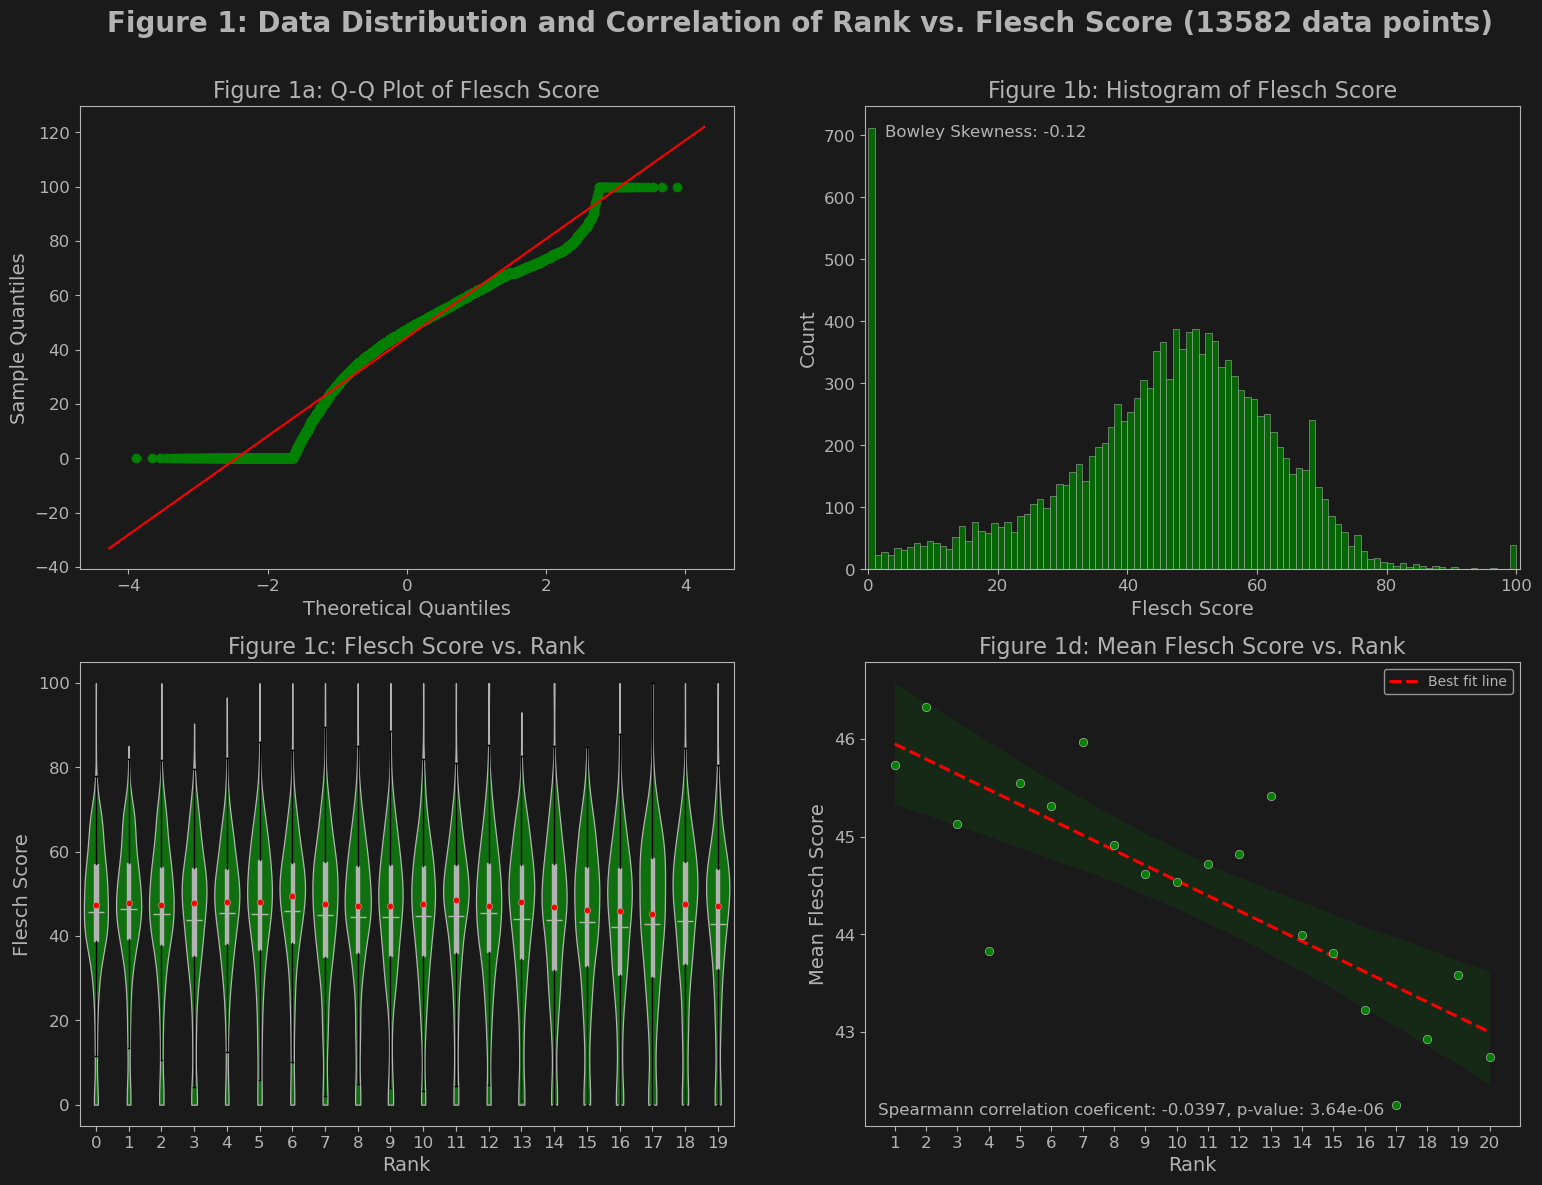

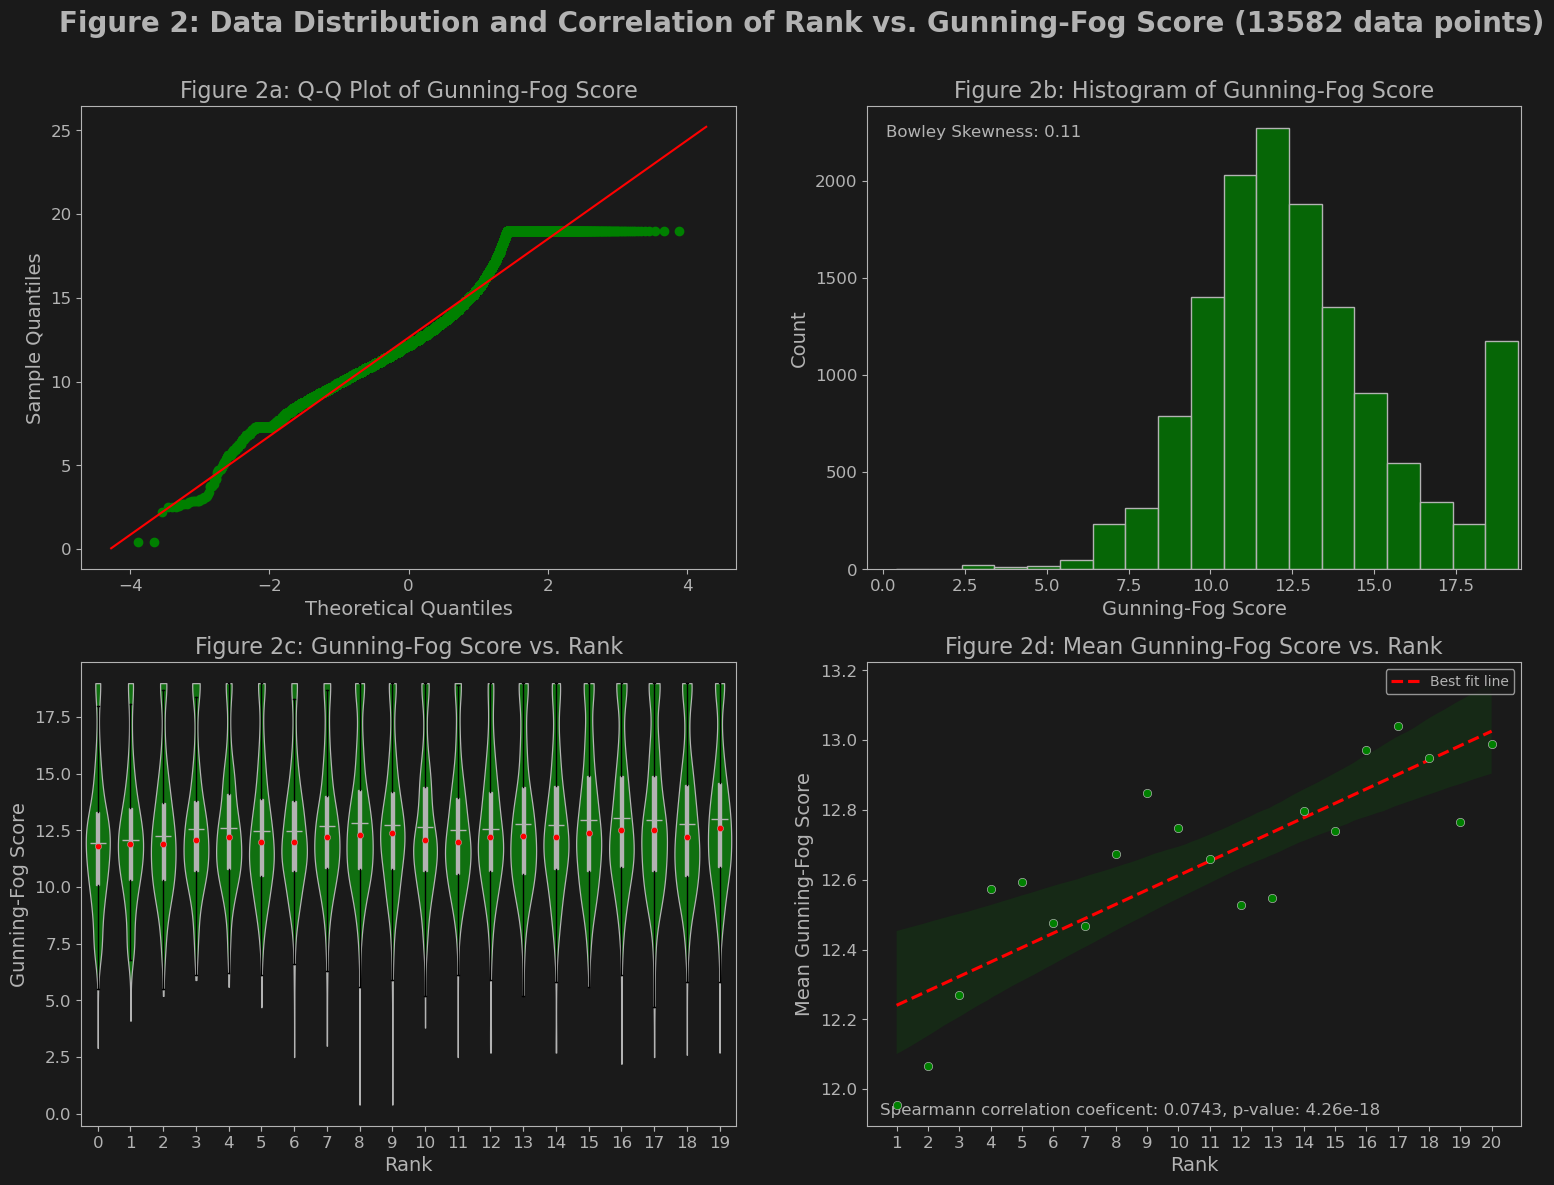

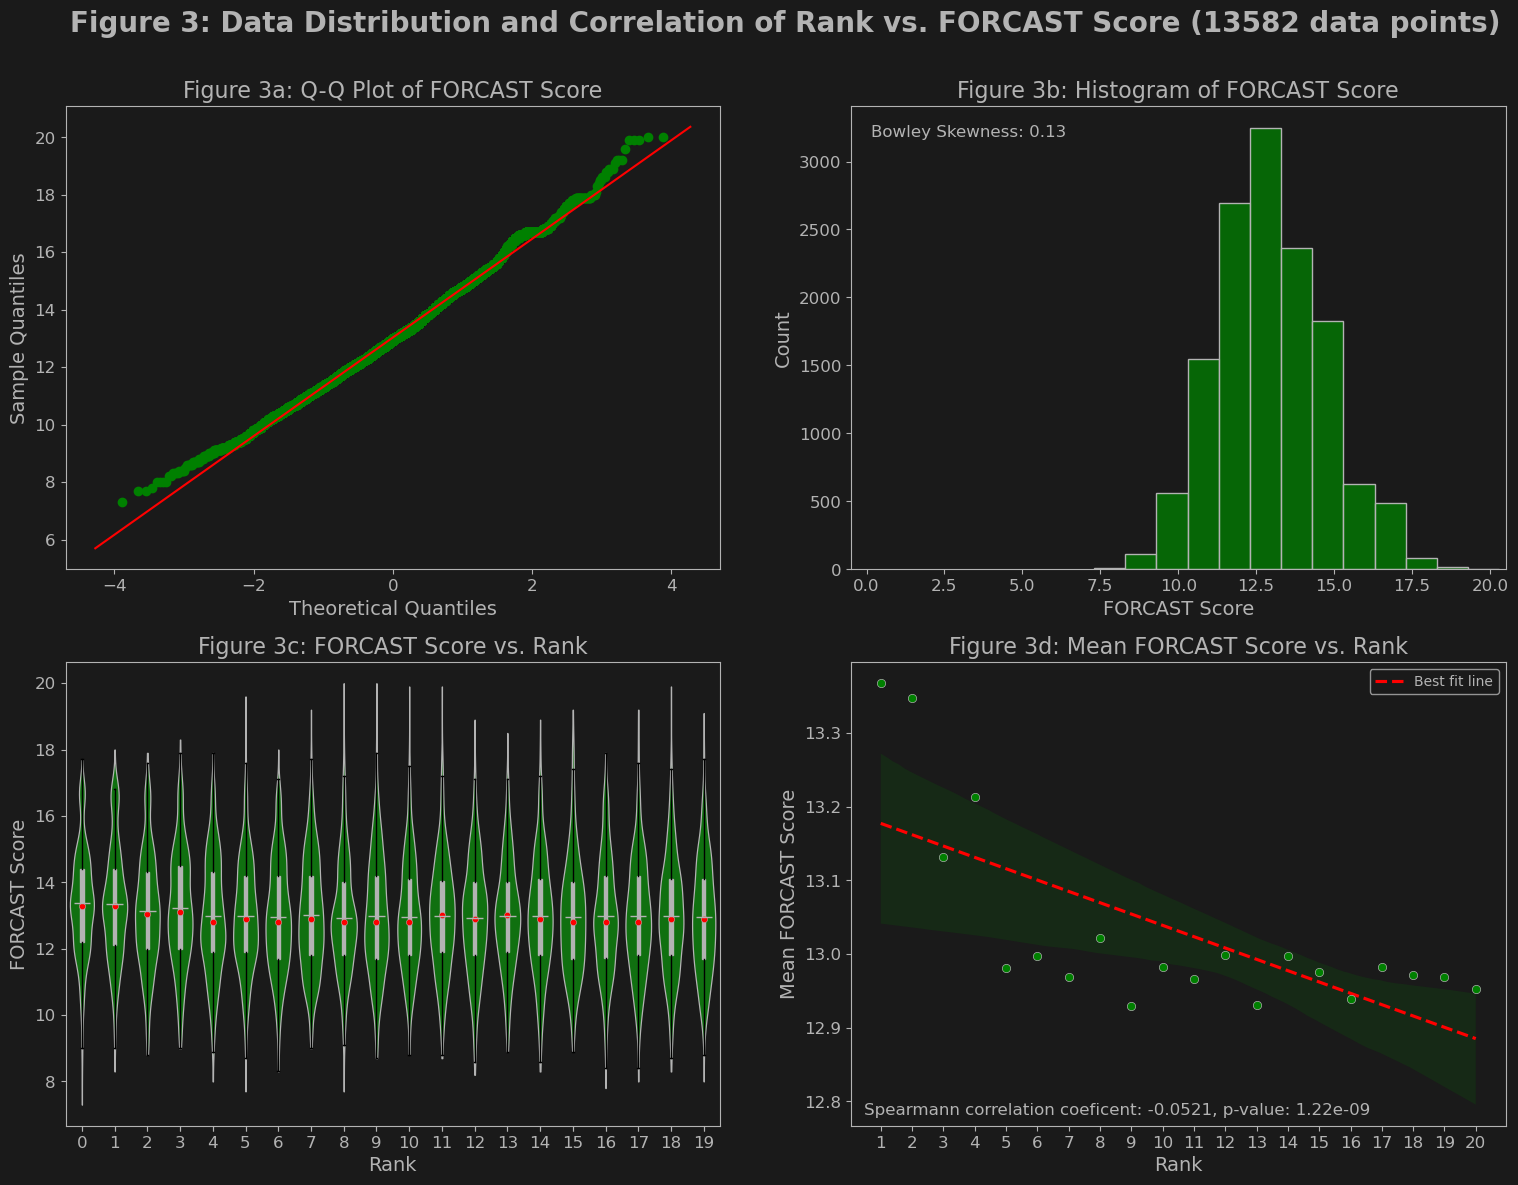

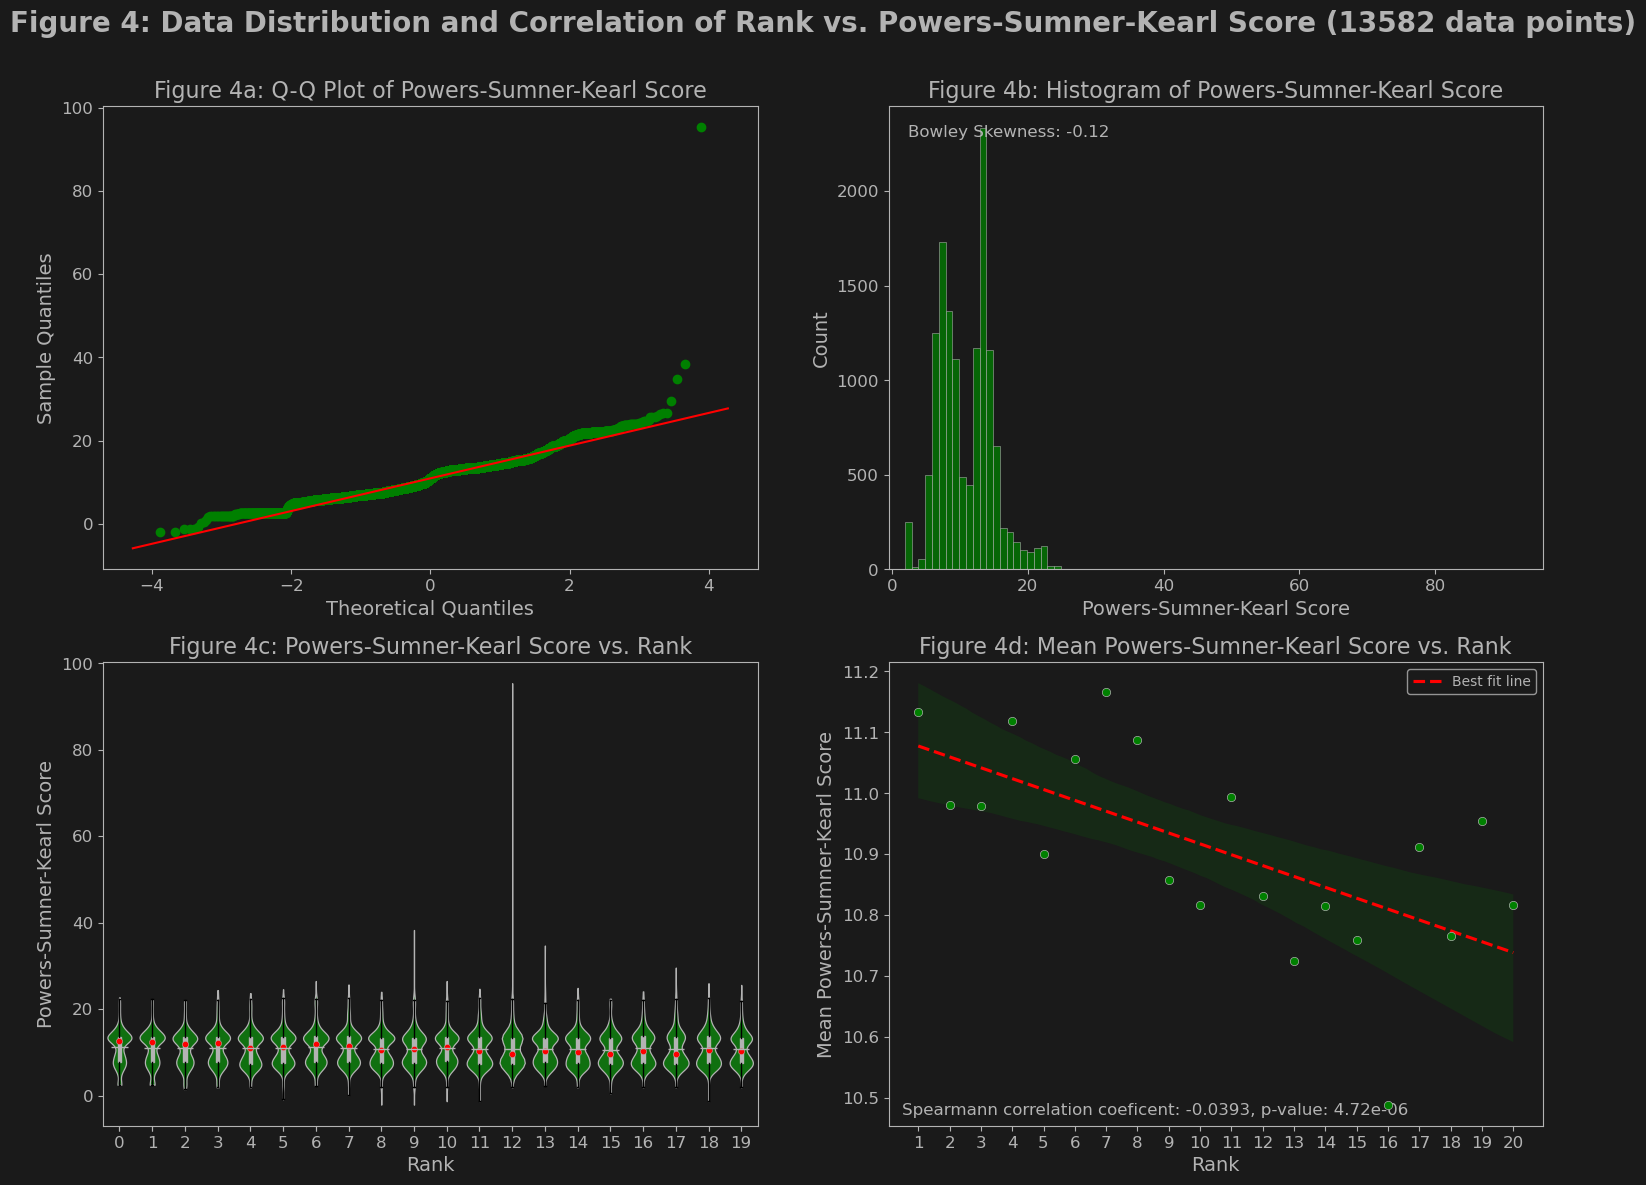

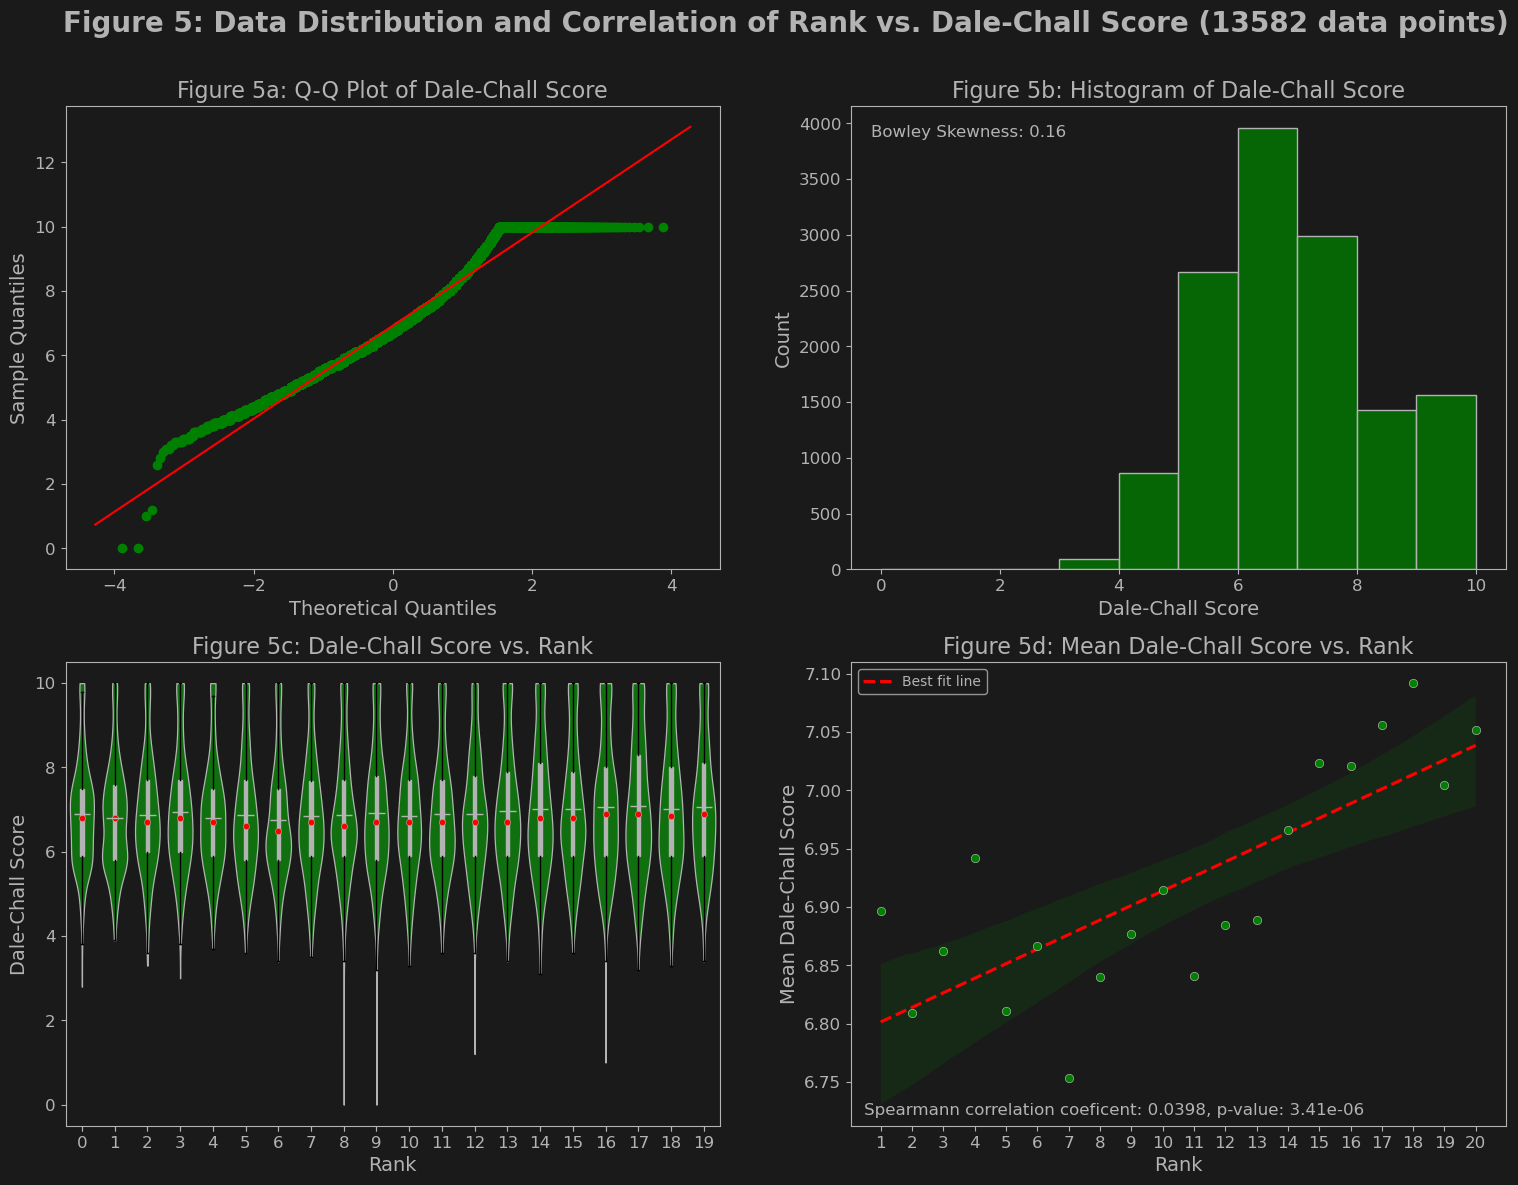

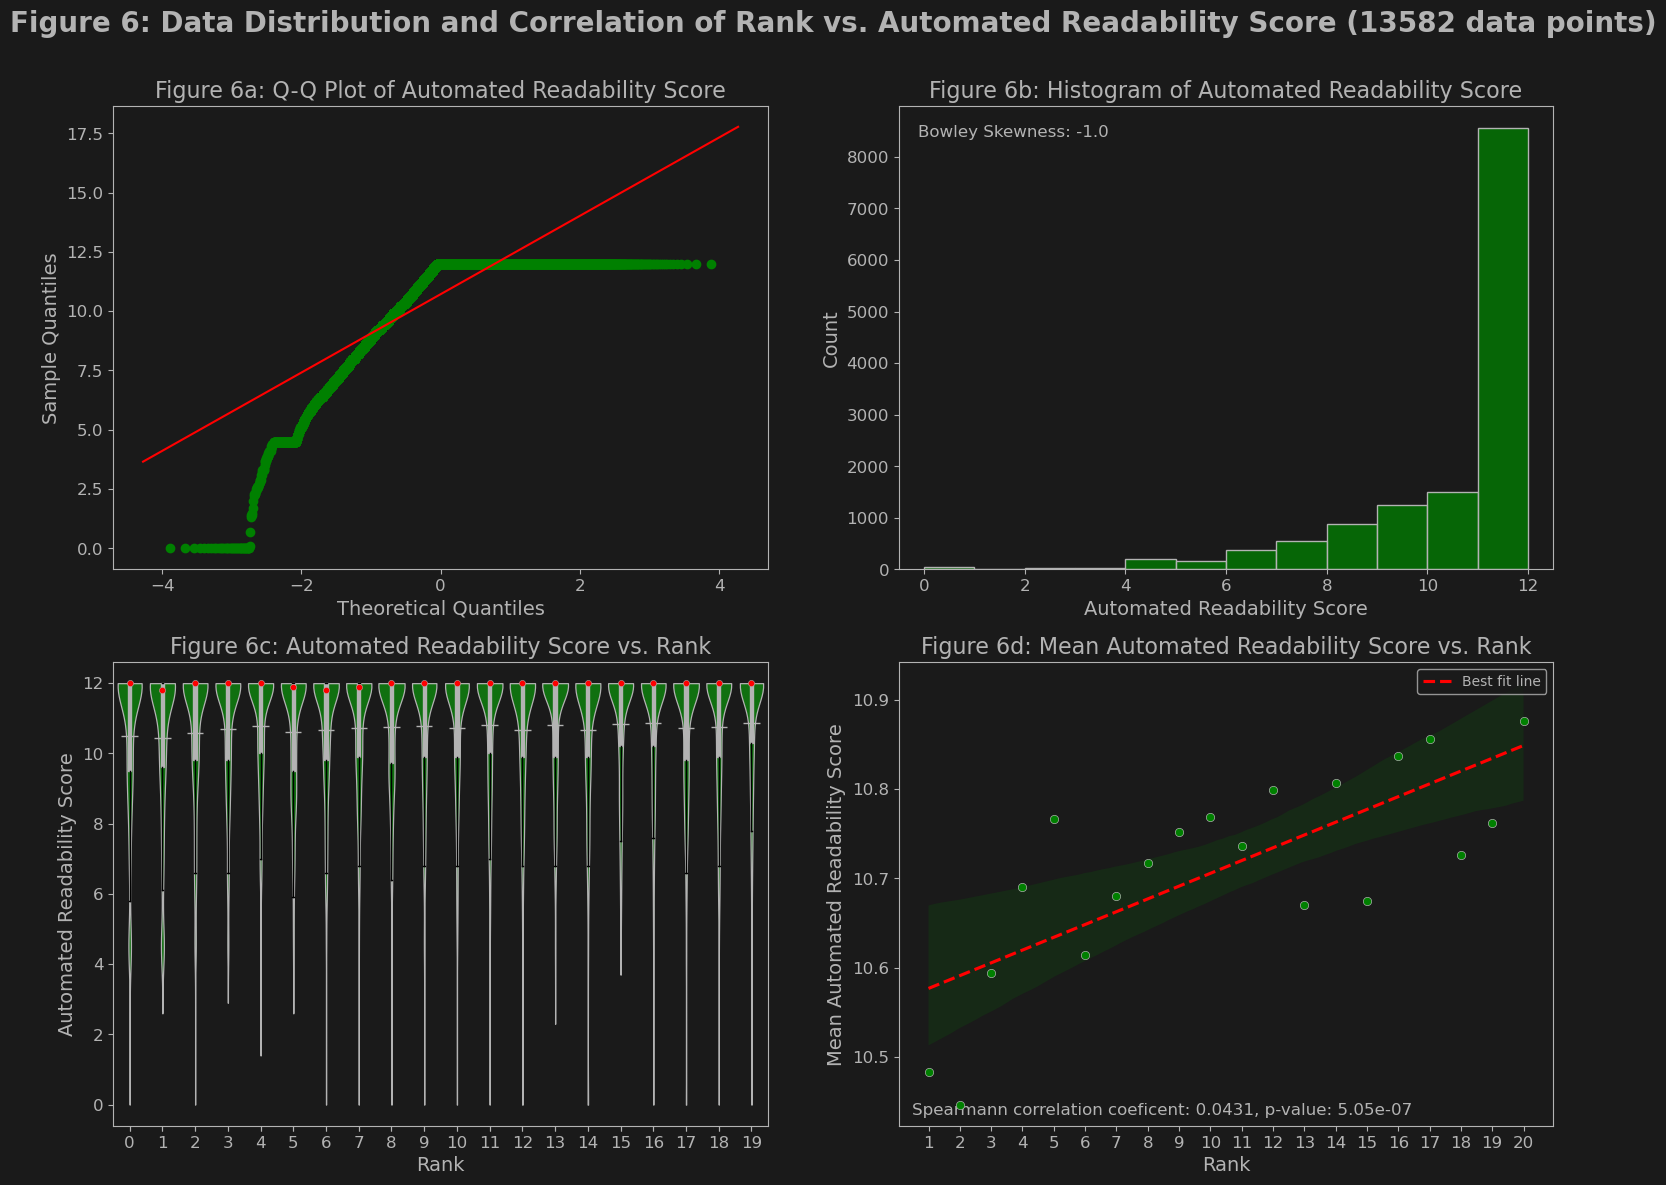

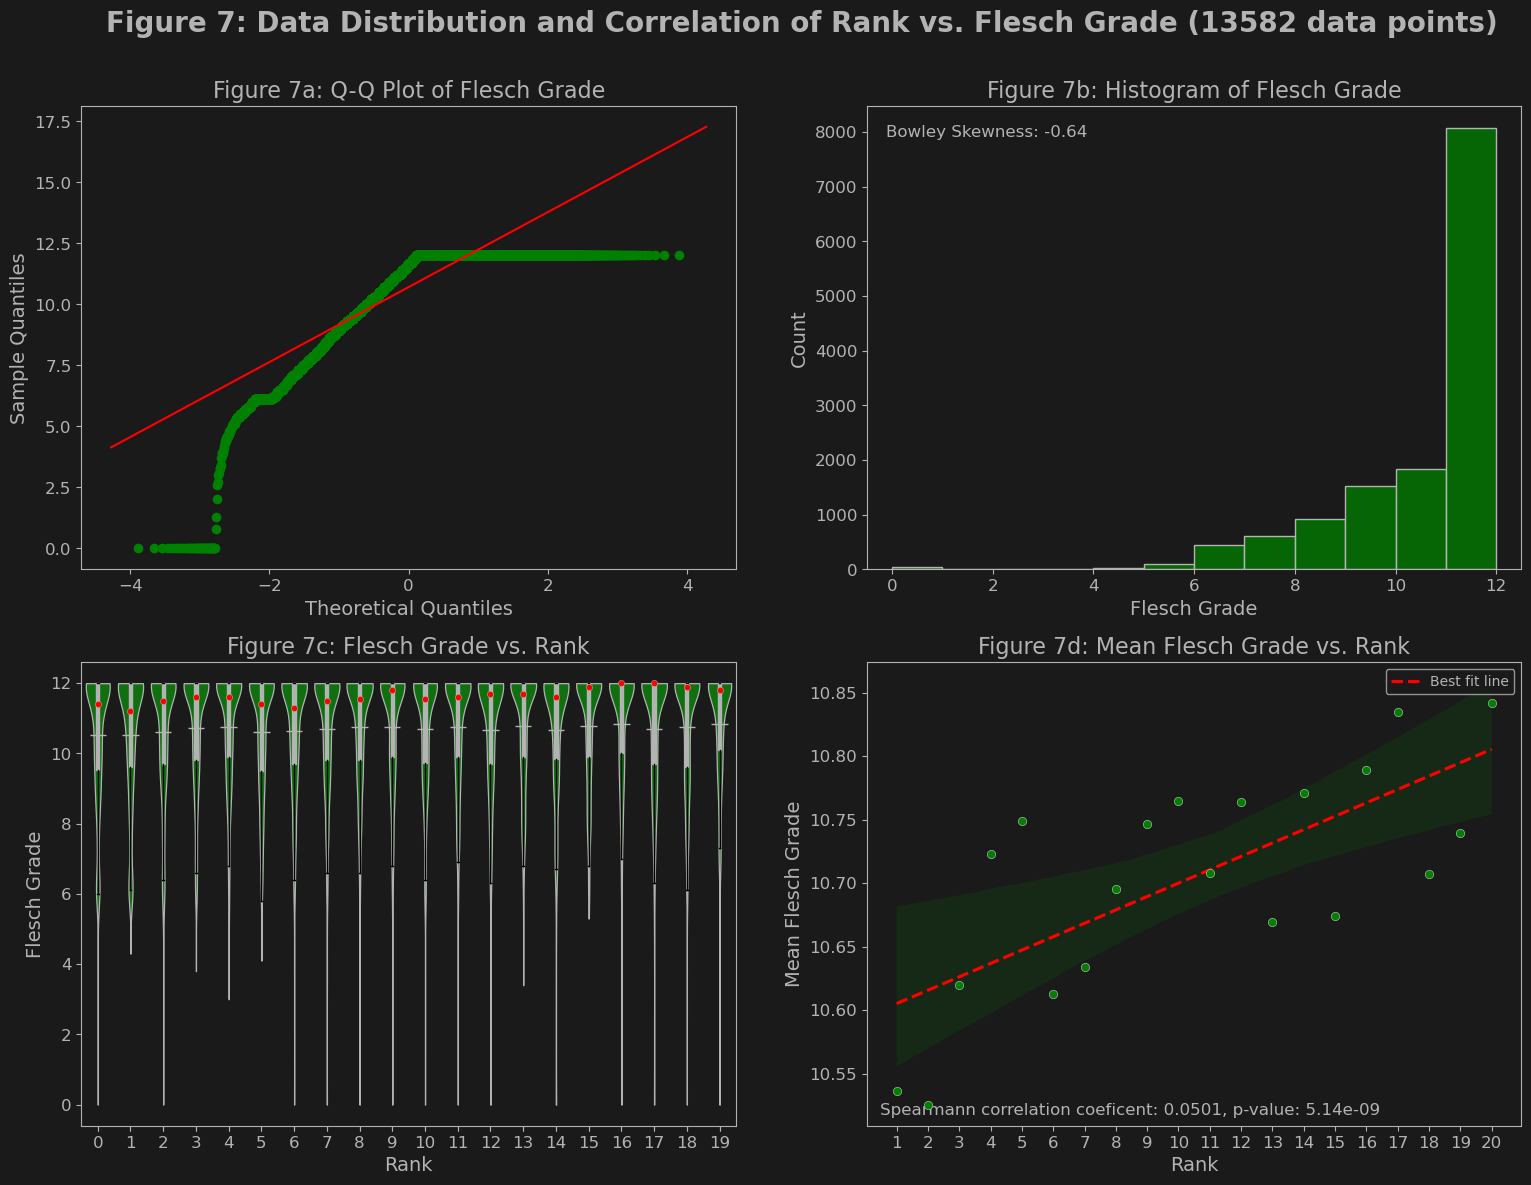

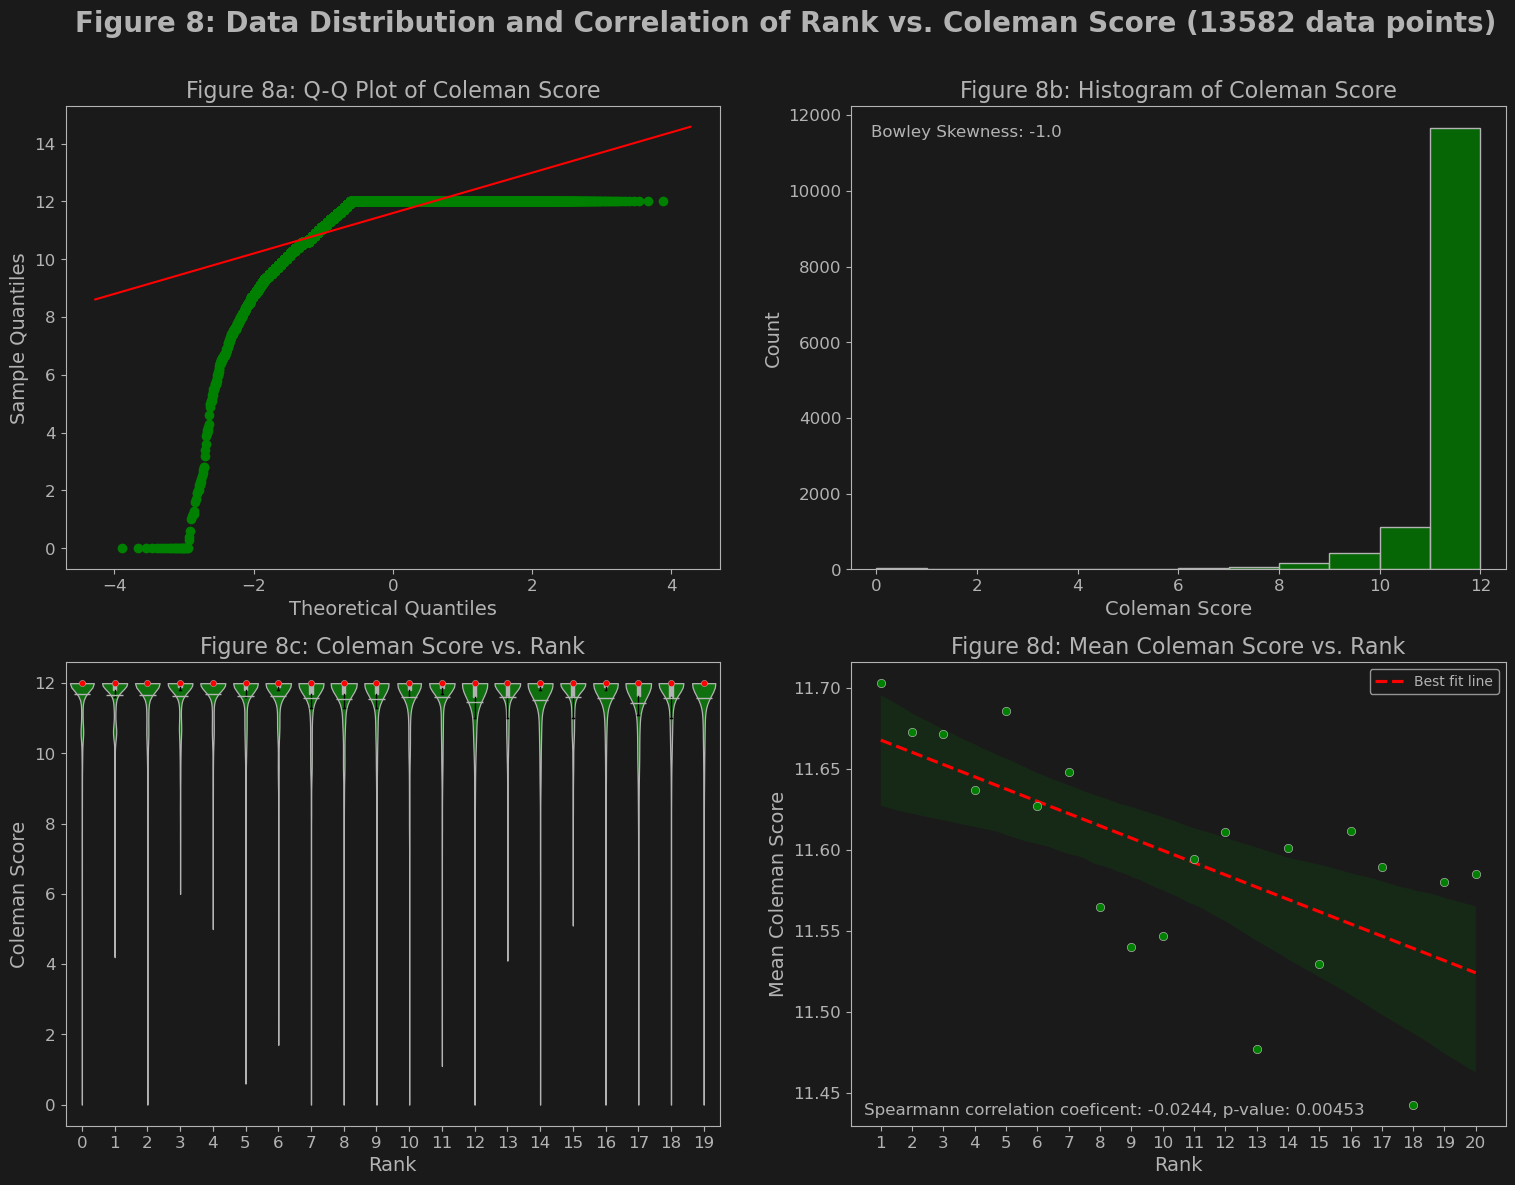

/tmp/ipykernel_305/412022907.py:29: RuntimeWarning: invalid value encountered in double_scalars
  bowley_skewness = round((((q3 - q2) - (q2 - q1))) / (q3 - q1), 2)


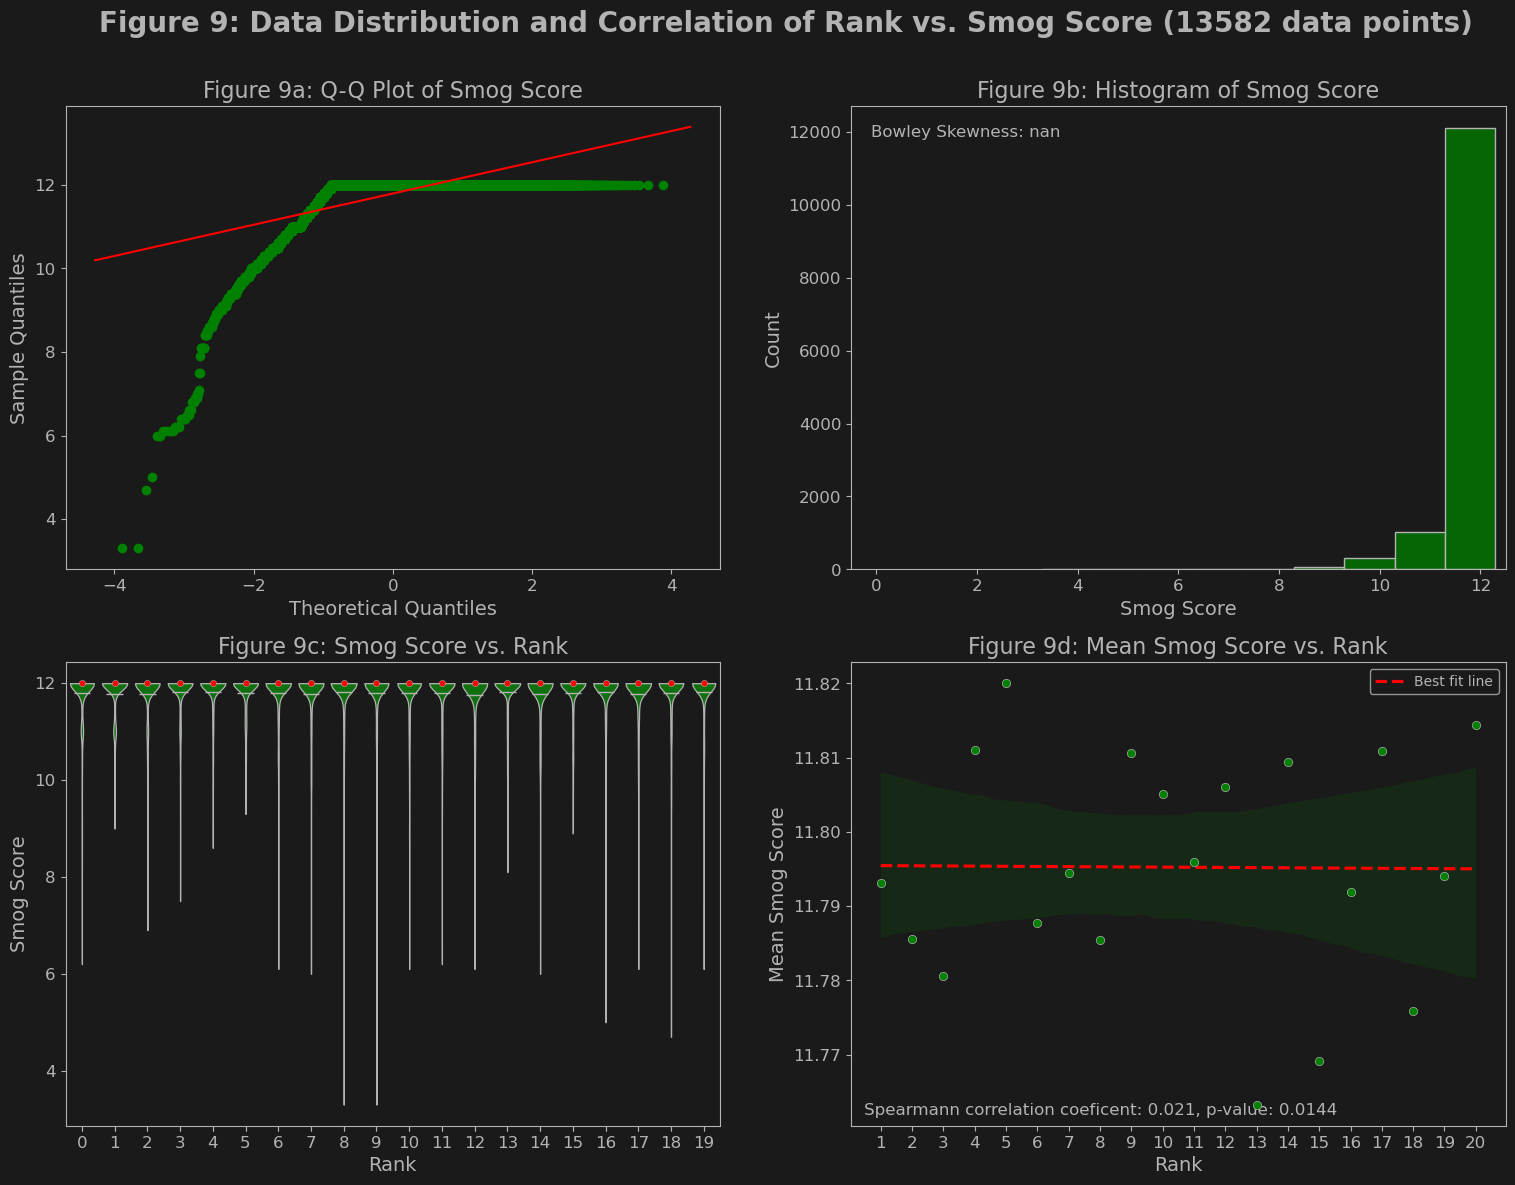

/tmp/ipykernel_305/412022907.py:29: RuntimeWarning: invalid value encountered in double_scalars
  bowley_skewness = round((((q3 - q2) - (q2 - q1))) / (q3 - q1), 2)


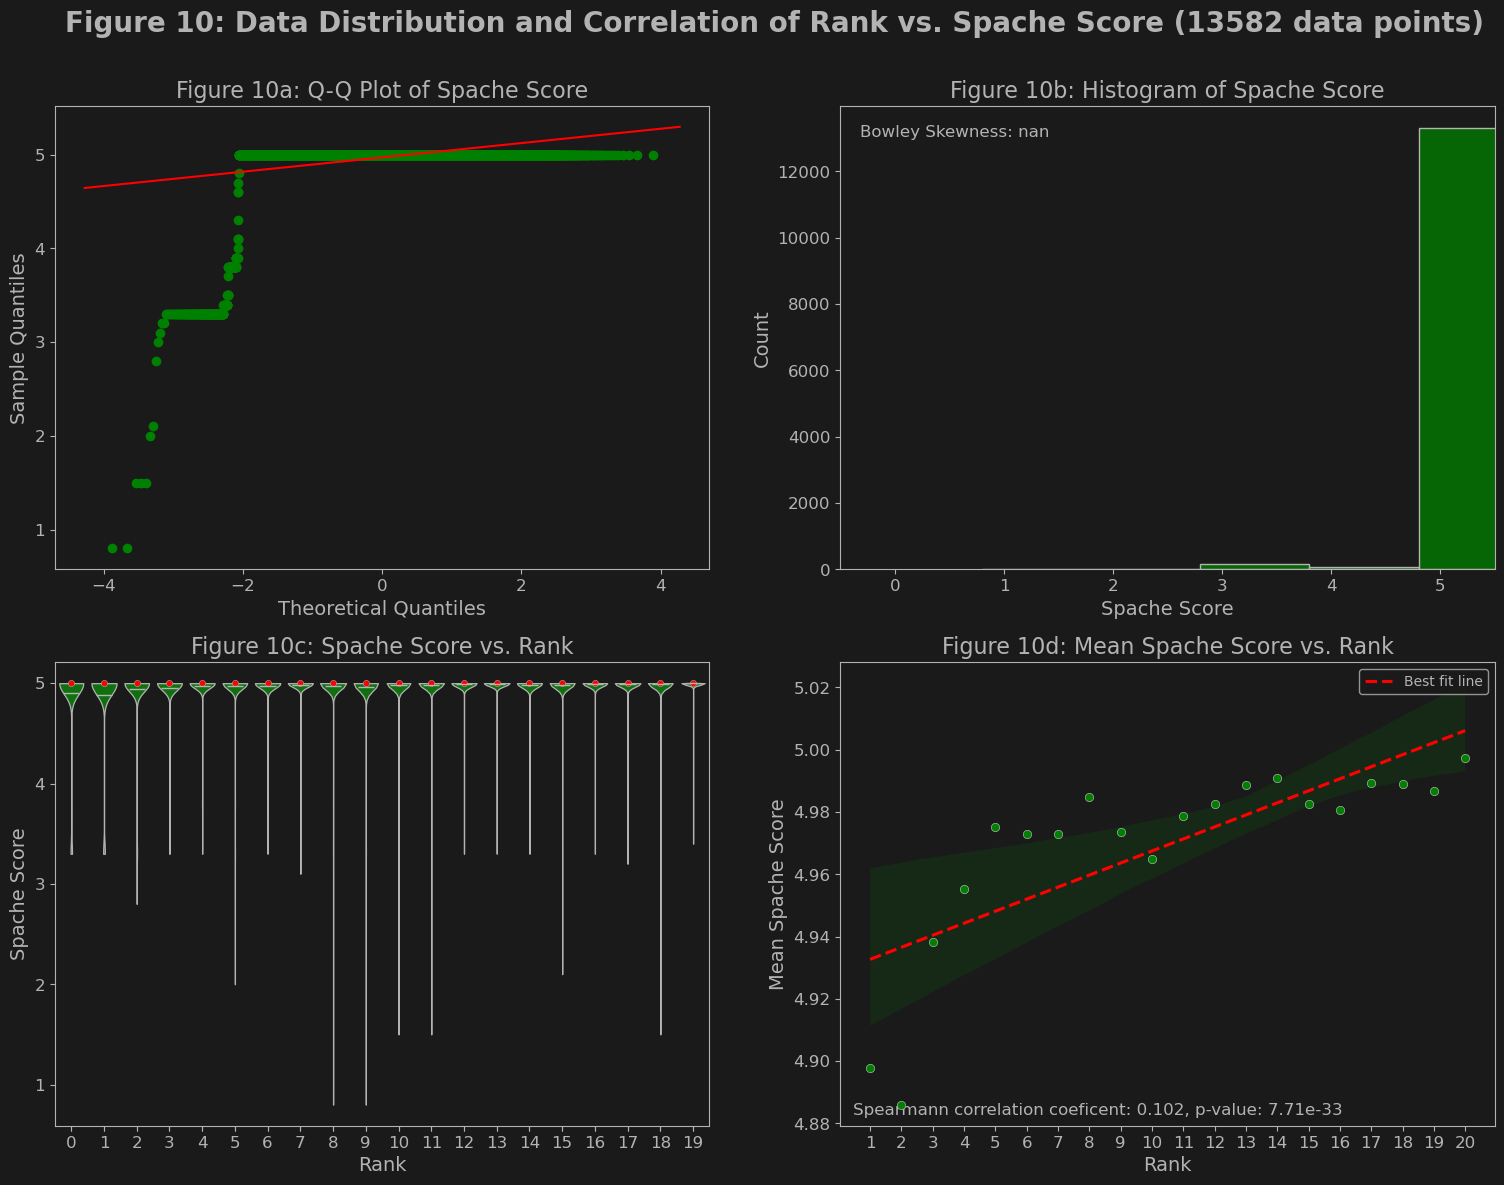

In [373]:
columns = ['Flesch Score', 'Gunning-Fog Score', 'FORCAST Score' ,'Powers-Sumner-Kearl Score' ,
           'Dale-Chall Score' ,'Automated Readability Score', 'Flesch Grade', 'Coleman Score' ,
           'Smog Score', 'Spache Score']
for i, col in enumerate (columns):
    multiplot(df, fig_name = f'Figure {i+1}', col_y = col, dark_mode = True)

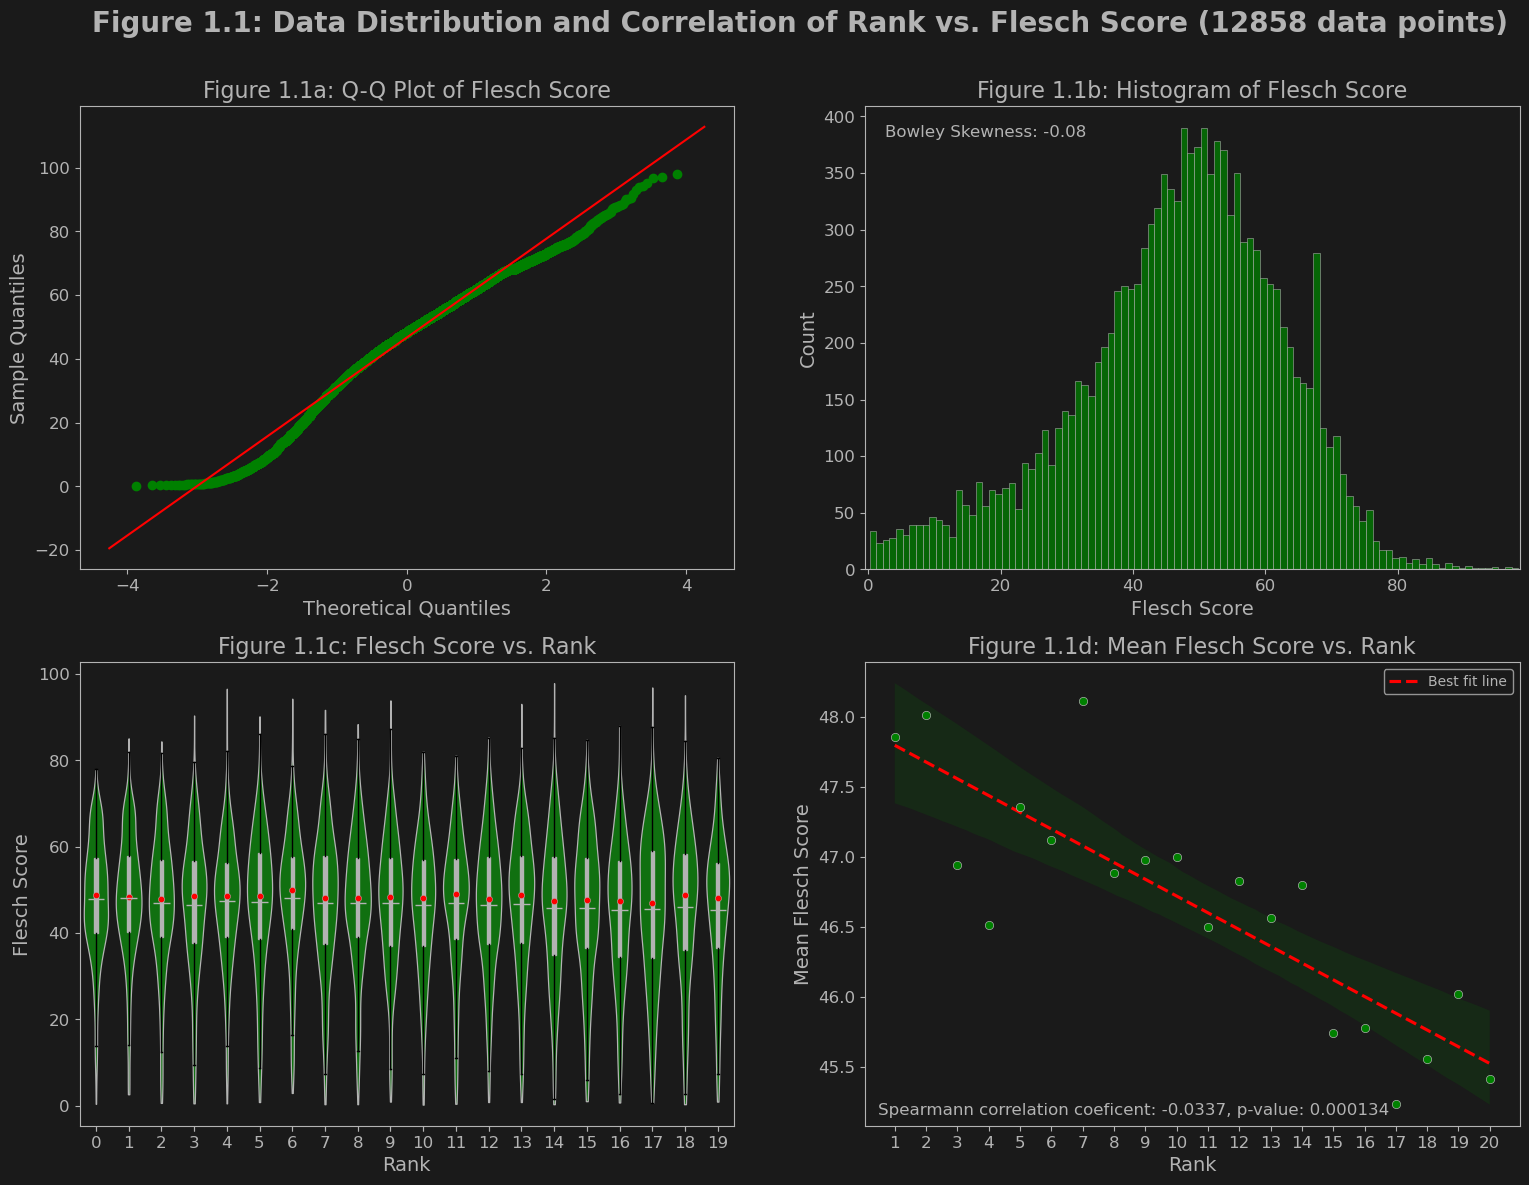

In [382]:
# 'Flesch Score' with outliers removed
col='Flesch Score'
df_flesch_score = df[(df[col] > 0.1) & (df[col] < 99.9)]
multiplot(df_flesch_score, fig_name='Figure 1.1', col_y=col, dark_mode=True)

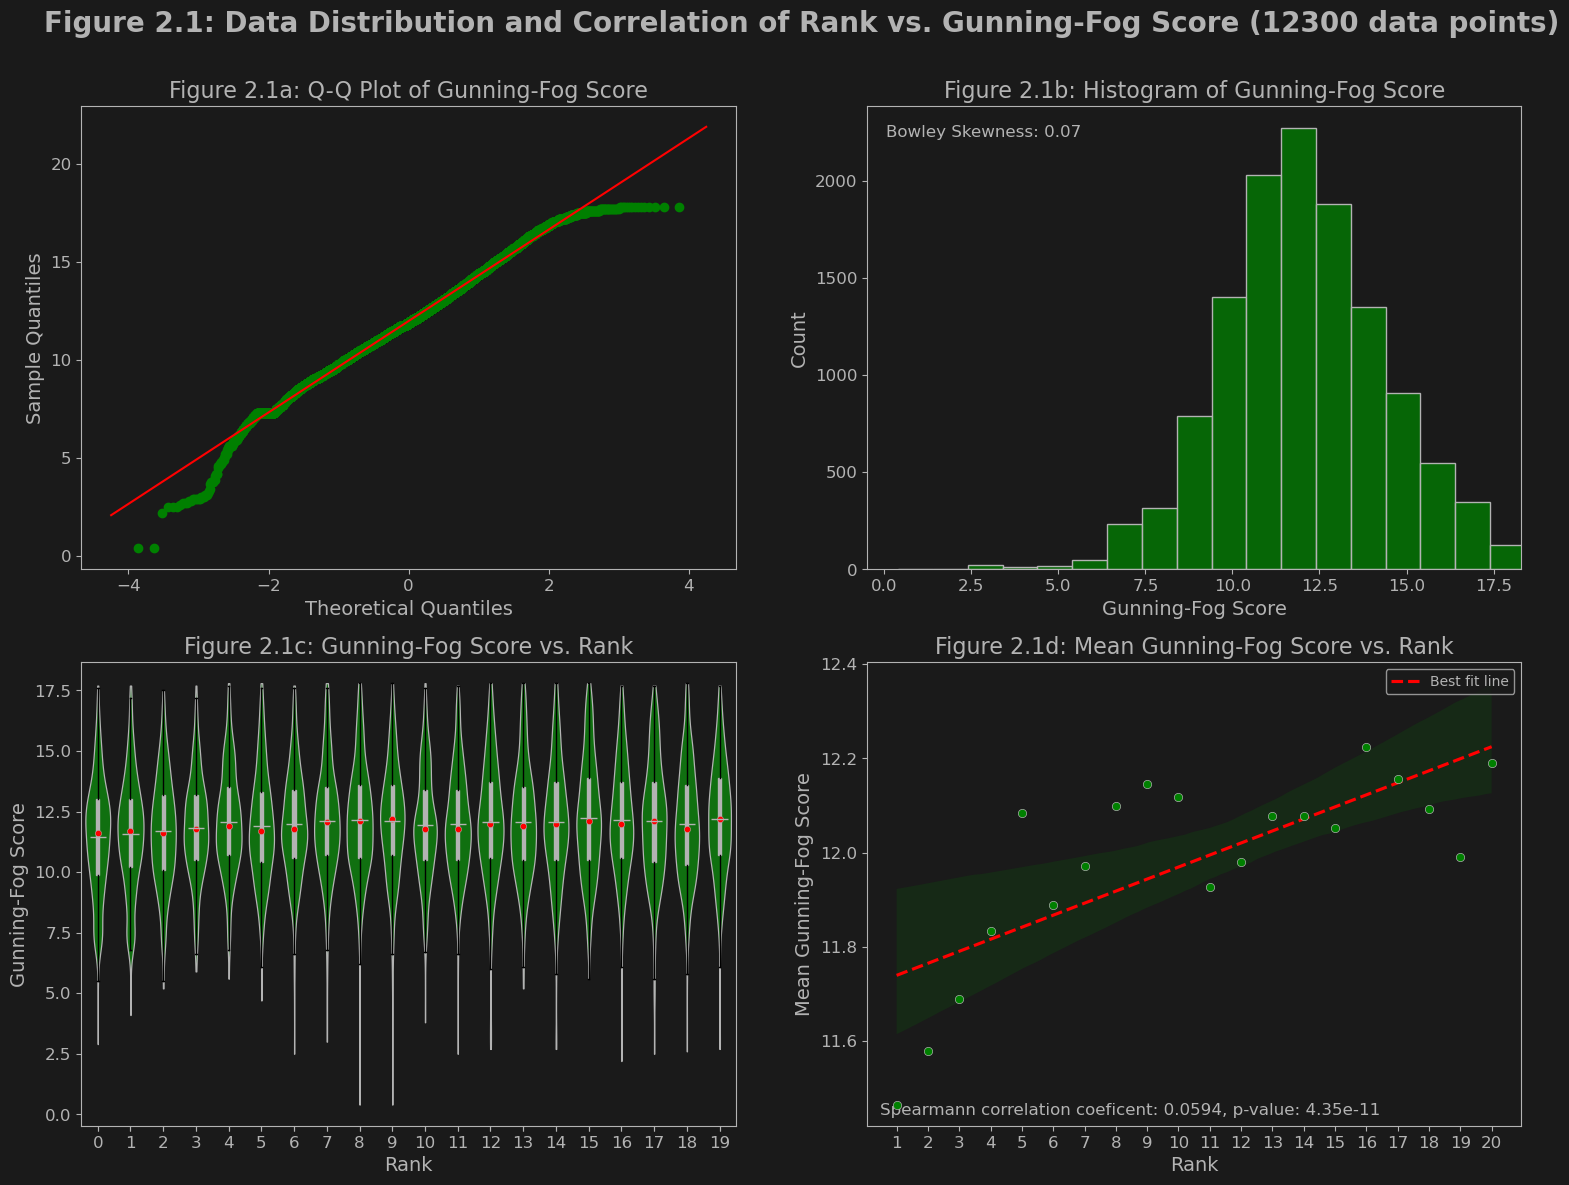

In [383]:
# 'Gunning-Fog Score' with outliers removed
col='Gunning-Fog Score'
df_gf = df[(df[col] > 0.0) & (df[col] < 17.9)]
multiplot(df_gf, fig_name='Figure 2.1', col_y=col, dark_mode=True)

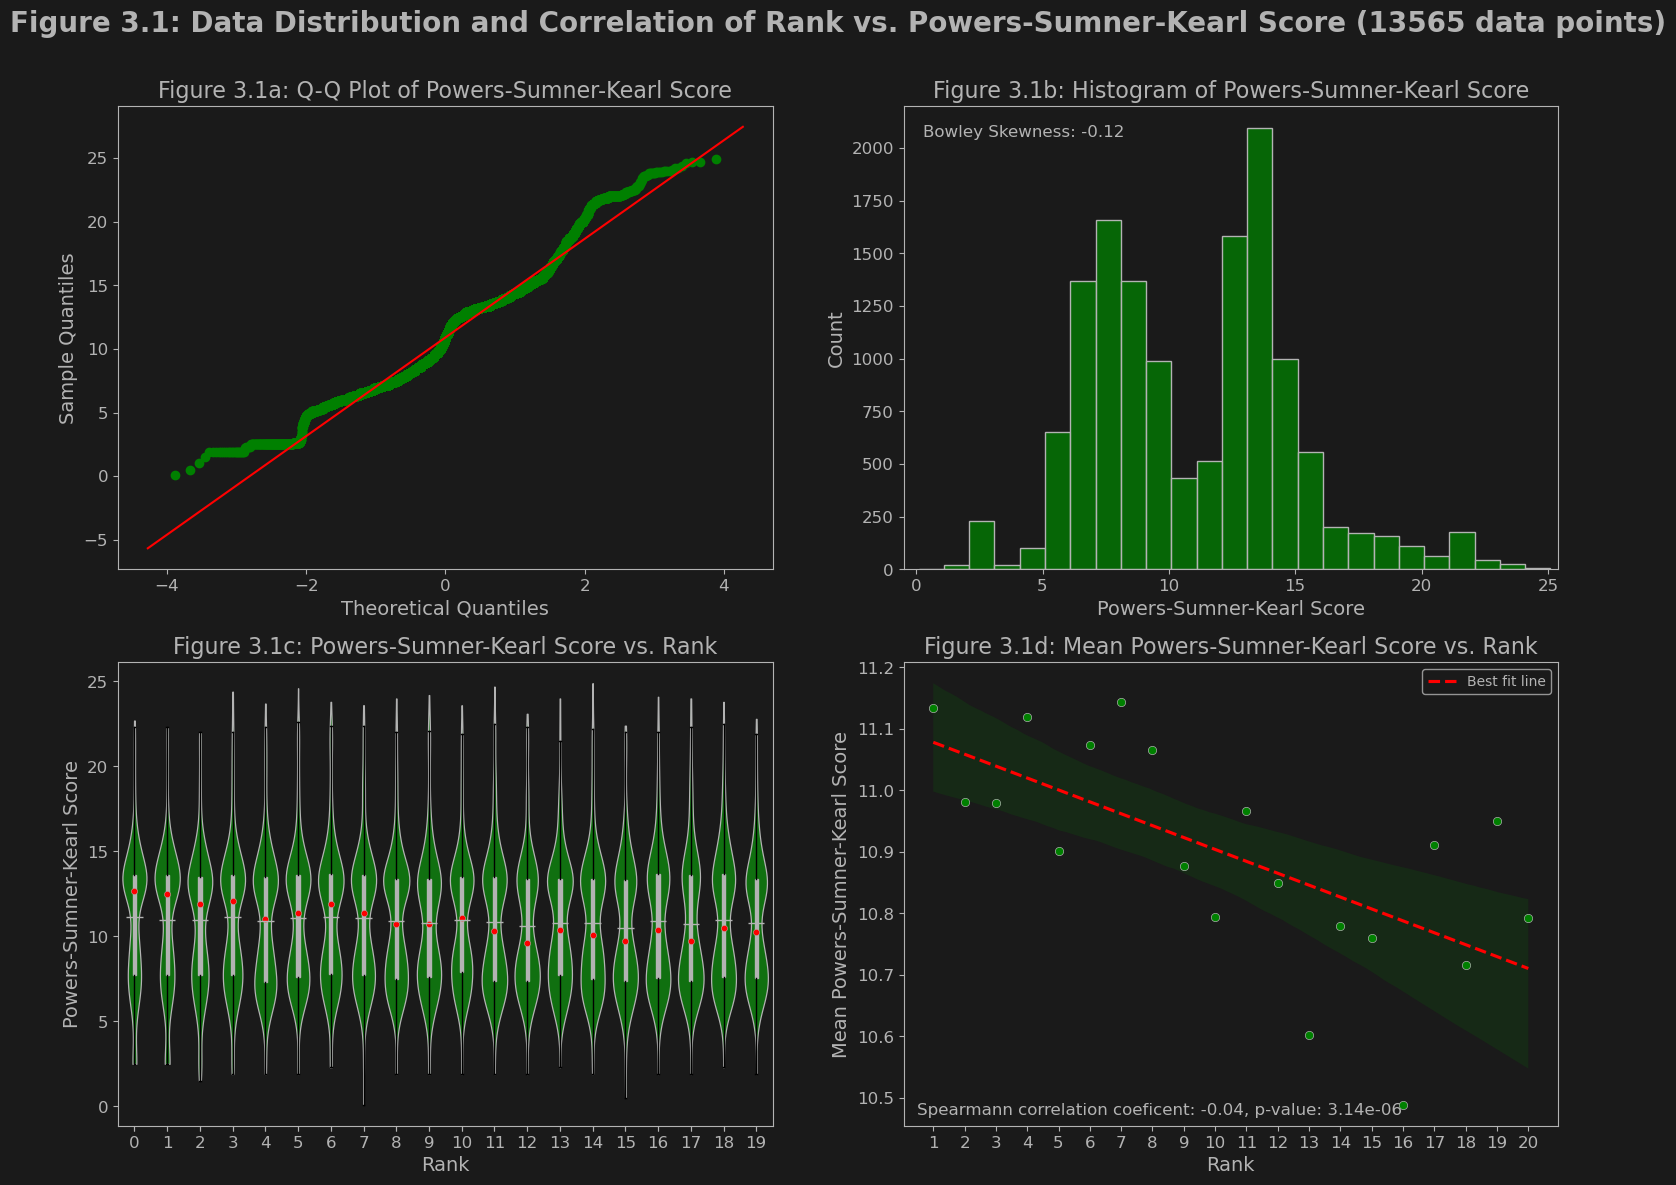

In [384]:
# 'Powers-Sumner-Kearl Score' outliers removed
col='Powers-Sumner-Kearl Score'
df_psk = df[(df[col] > 0.0) & (df[col] < 25)]
multiplot(df_psk, fig_name='Figure 3.1', col_y=col, dark_mode=True)

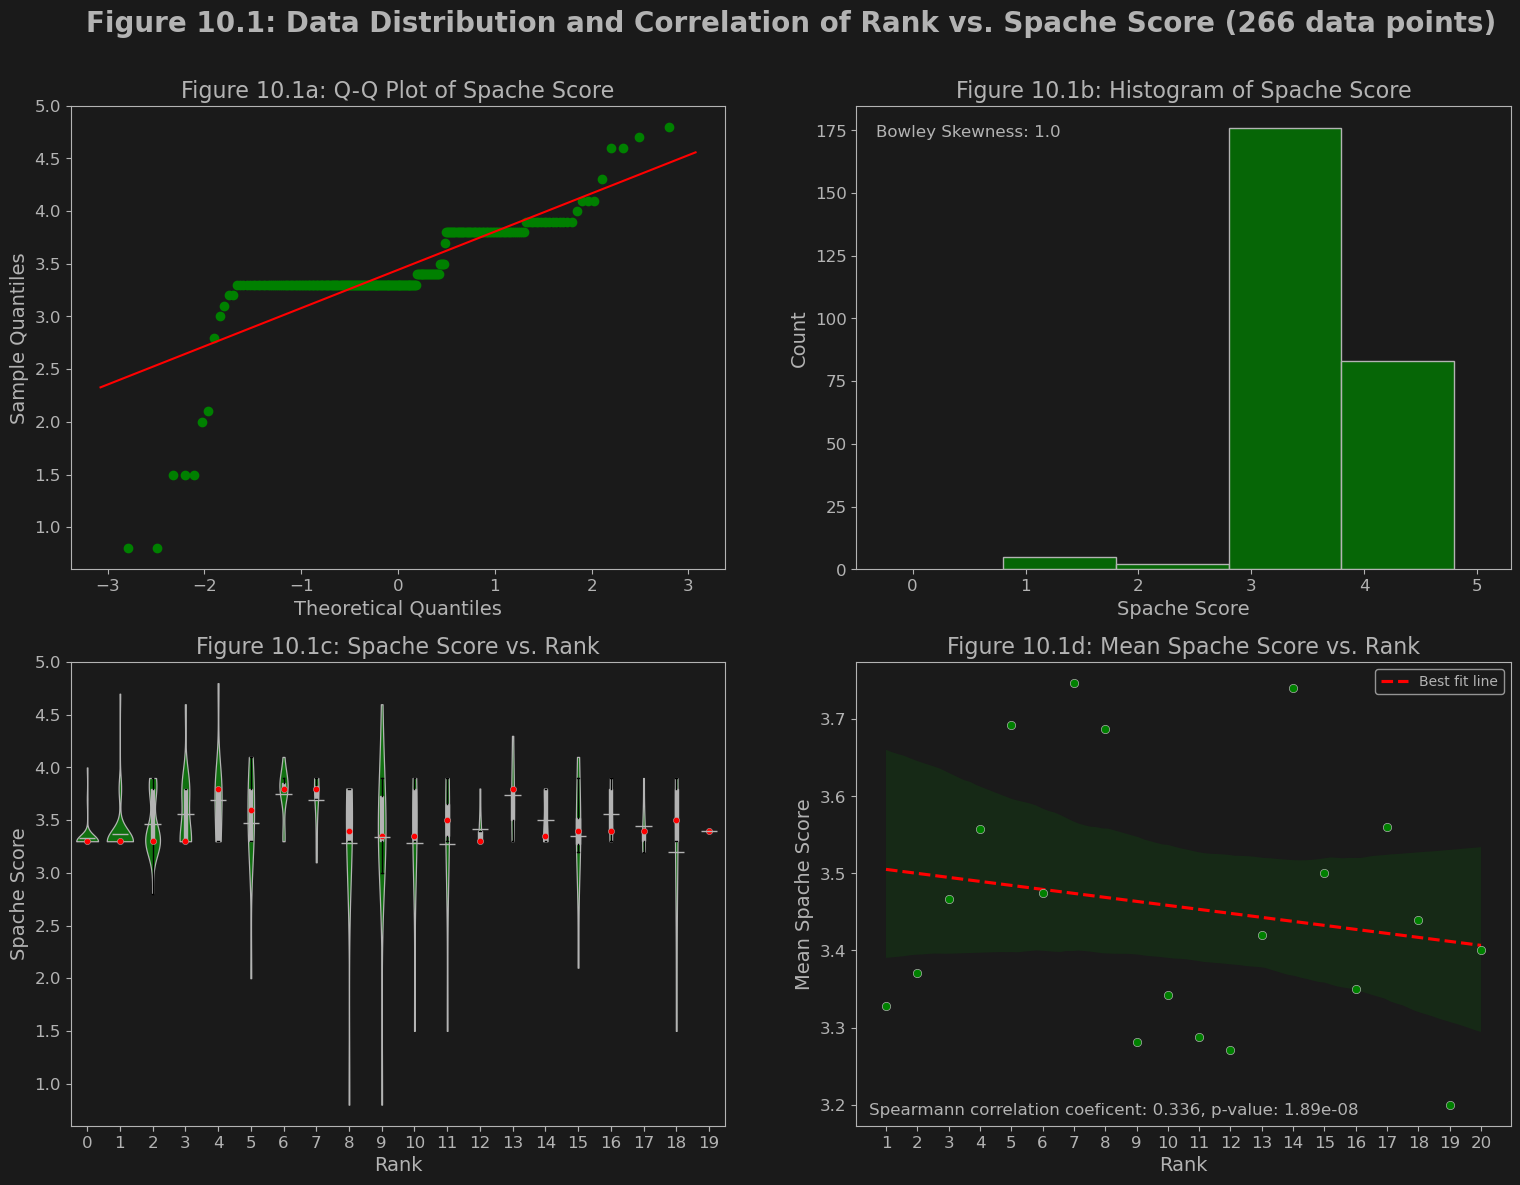

In [385]:
# 'Spache Score' with outliers removed (sucks slightly less)
col='Spache Score'
df_spache = df[(df[col] > 0.0) & (df[col] < 5)]
multiplot(df_spache, fig_name='Figure 10.1', col_y=col, dark_mode=True)

In [398]:
# columns = ['Smog Score', 'Coleman Score', 'Automated Readability Score',
#        'Dale-Chall Score', 'Powers-Sumner-Kearl Score', 'FORCAST Score',
#        'Spache Score', 'Gunning-Fog Score', 'Flesch Grade', 'Flesch Score']
# for col_2 in columns:
#     full_plot(df, 'rank', col_2)

In [ ]:
df.columns

Index(['rank', 'Flesch Score', 'Gunning-Fog Score', 'FORCAST Score',
       'Powers-Sumner-Kearl Score', 'Dale-Chall Score',
       'Automated Readability Score', 'Coleman Score', 'Flesch Grade ',
       'Smog Score', 'Spache Score'],
      dtype='object')

In [388]:
def plot (df, col_1, col_2):

        

    # Plot col_1 vs col_2 as an XY scatter plot
    plt.scatter(df[col_1], df[col_2])


    # Set axis labels and plot title
    plt.xlabel(col_1)
    plt.ylabel(col_2)
    plt.title(f'XY Scatter Plot of {col_1} vs {col_2}')

    # Show the plot
    plt.show()

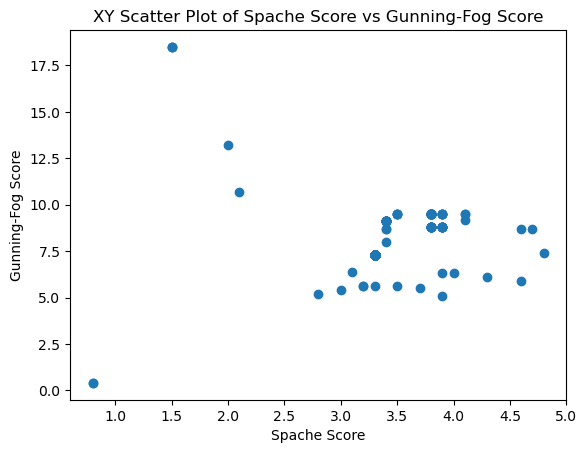

266

In [394]:
col_1 = 'Spache Score'
col_2 = 'Gunning-Fog Score'
x = df[df['Spache Score'] < 5]
plot (x, col_1, col_2)
len(x)


In [395]:
def plot(df, col_1, col_2):

    # Load data into a pandas DataFrame
    #df = pd.read_csv('data.csv')

    # Plot col_1 vs col_2 as an XY scatter plot
    plt.scatter(df[col_1], df[col_2])

    # Calculate the best-fit line using linear regression
    slope, intercept, r_value, p_value, std_err = st.linregress(df[col_1], df[col_2])
    line = slope * df[col_1] + intercept

    # Plot the best-fit line
    plt.plot(df[col_1], line, color='red')

    # Set axis labels and plot title
    plt.xlabel(col_1)
    plt.ylabel(col_2)
    plt.title(f'XY Scatter Plot of {col_1} vs {col_2}')

    # Show the plot
    plt.show()

In [437]:
def single_plot(df, col_x, col_y):

    # Color variables
    bg_color = '#222222'
    text_color = 'white'
    border_color = 'white'
    tick_color = 'white'
    point_color = 'green'
    line_color = 'red'

    # Font size variables
    label_font_size = 12
    title_font_size = 14
    tick_font_size = 10
    legend_font_size = 10

    # Create the grid of subplots
    fig, ax = plt.subplots(figsize=(6, 6))
    fig.patch.set_facecolor(bg_color)

    # Calculate correlation coefficient and p-value
    corr_coef, p_value = st.spearmanr(df[col_x], df[col_y])

    # Create a scatter plot of the column against 'rank'
    scatter = ax.scatter(df[col_x], df[col_y], color=point_color)

    # Add a best fit line
    slope, intercept, r_value, p_value, std_err = st.linregress(df[col_x], df[col_y])
    x_vals = np.array(ax.get_xlim())
    y_vals = intercept + slope * x_vals
    line = ax.plot(x_vals, y_vals, color=line_color, label='Best Fit Line')

    # Set axis labels, title, and their colors and font sizes
    ax.set_xlabel(col_x, color=text_color, fontsize=label_font_size)
    ax.set_ylabel(col_y, color=text_color, fontsize=label_font_size)
    ax.set_title(f'{col_x} vs {col_y}\nCorr Coef: {corr_coef:.2f} | P-value: {p_value:.2e}', color=text_color, fontsize=title_font_size)

    # Set tick and border colors, and tick font size
    ax.tick_params(axis='x', colors=tick_color, labelsize=tick_font_size)
    ax.tick_params(axis='y', colors=tick_color, labelsize=tick_font_size)
    ax.spines['bottom'].set_color(border_color)
    ax.spines['top'].set_color(border_color)
    ax.spines['right'].set_color(border_color)
    ax.spines['left'].set_color(border_color)

    # Set the plot background color
    ax.set_facecolor(bg_color)

    # Add legend and set font size and color
    handles, labels = ax.get_legend_handles_labels()
    handles = [line[0]]
    labels = ['Best Fit Line']
    ax.legend(handles=handles, labels=labels, fontsize=legend_font_size, facecolor=bg_color, edgecolor=border_color)
    leg = ax.get_legend()
    for text in leg.get_texts():
        text.set_color(text_color)

    plt.tight_layout()
    plt.show()

In [438]:
df.columns

Index(['rank', 'Flesch Score', 'Gunning-Fog Score', 'FORCAST Score',
       'Powers-Sumner-Kearl Score', 'Dale-Chall Score',
       'Automated Readability Score', 'Flesch Grade', 'Coleman Score',
       'Smog Score', 'Spache Score'],
      dtype='object')

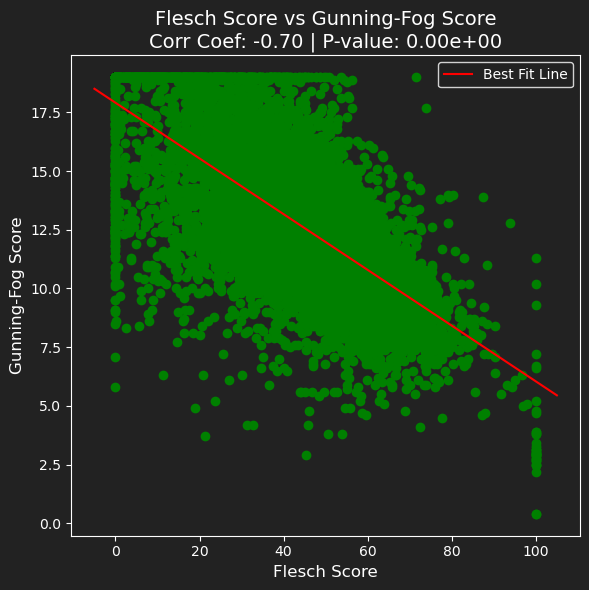

In [445]:
col_x = 'Flesch Score'
col_y = 'Gunning-Fog Score'
single_plot(df, col_x, col_y)

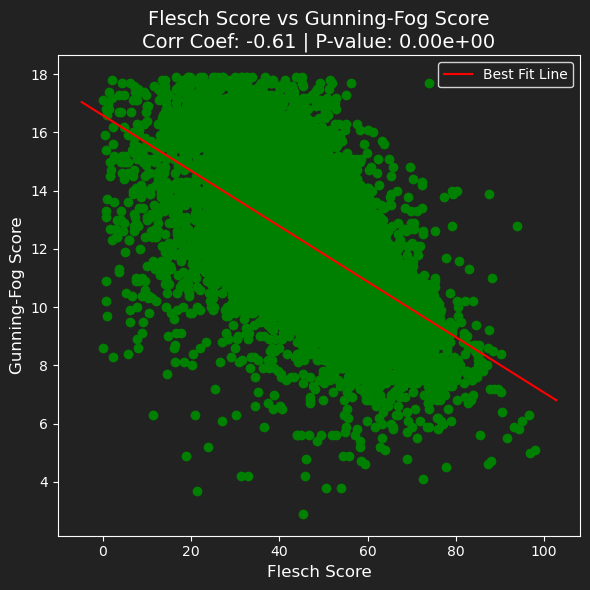

In [443]:
col_x = 'Flesch Score'
col_y = 'Gunning-Fog Score'
x = df[(df[col_x] > 0) & (df[col_x] < 100)]
x = x[x[col_y] < 18]
single_plot(x, col_x, col_y)

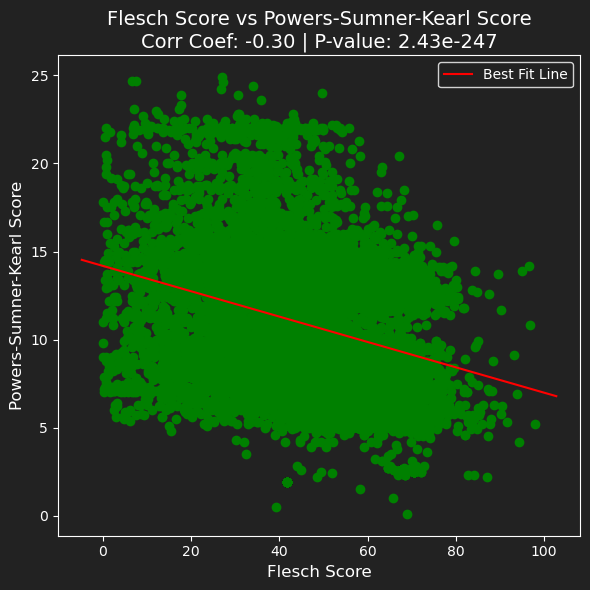

In [441]:
col_x = 'Flesch Score'
col_y = 'Powers-Sumner-Kearl Score'
x = df[(df[col_x] > 0) & (df[col_x] < 100)]
x = x[(x[col_y] > 0.0) & (x[col_y] < 25)]
single_plot(x, col_x, col_y)

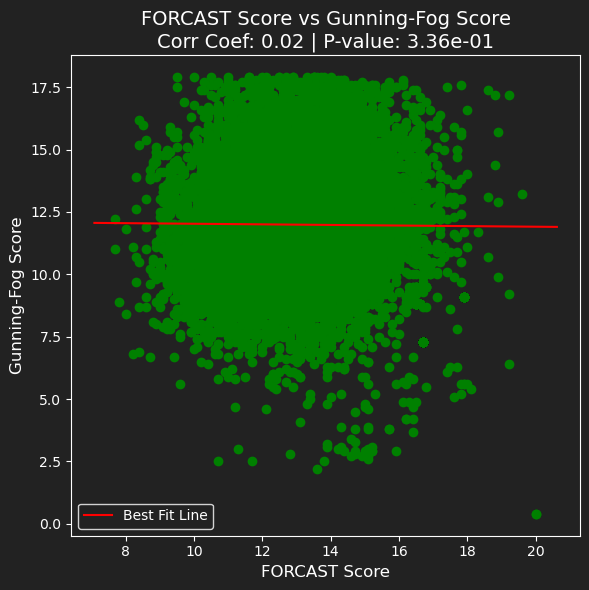

In [444]:
col_x = 'FORCAST Score'
col_y = 'Gunning-Fog Score'
x = df[(df[col_x] > 0) & (df[col_x] < 100)]
x = x[x[col_y] < 18]
single_plot(x, col_x, col_y)

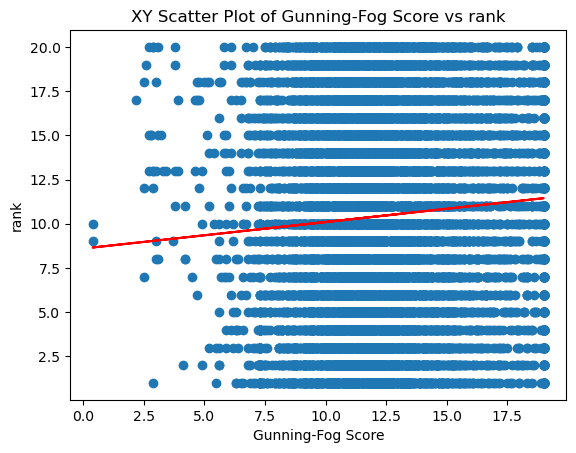

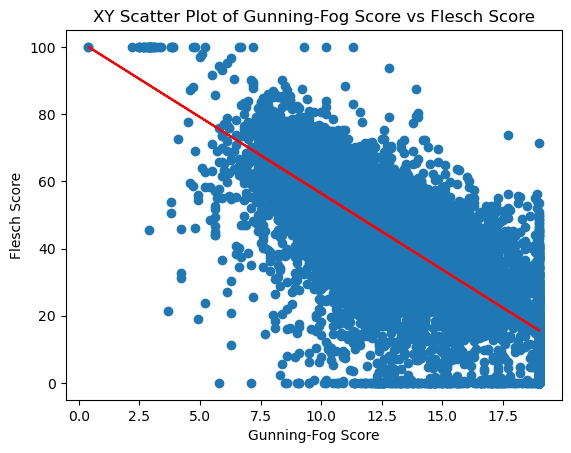

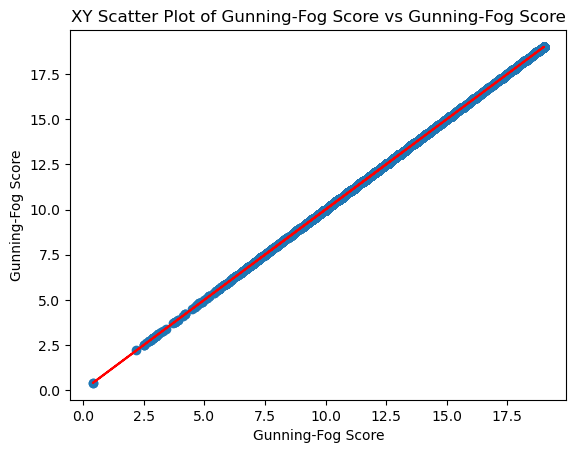

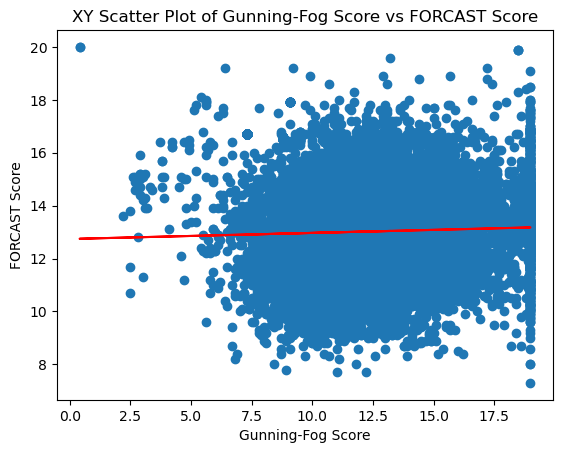

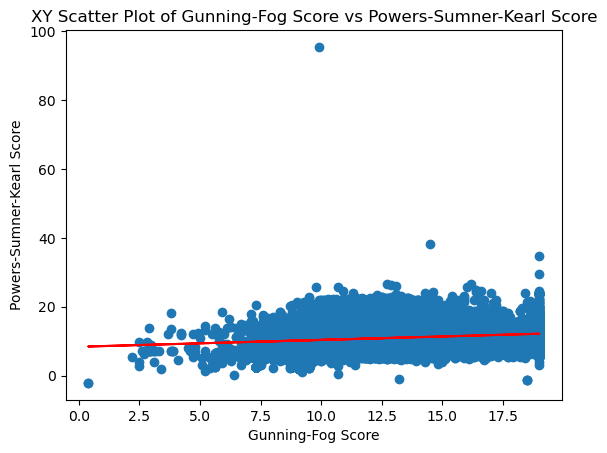

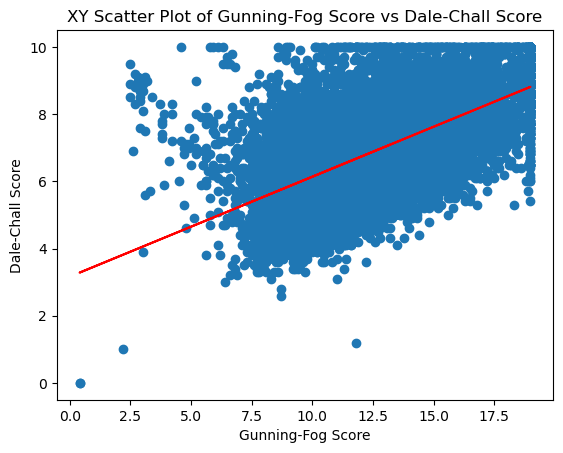

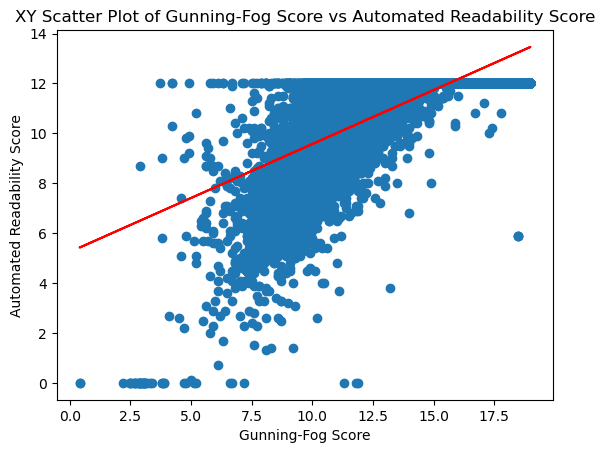

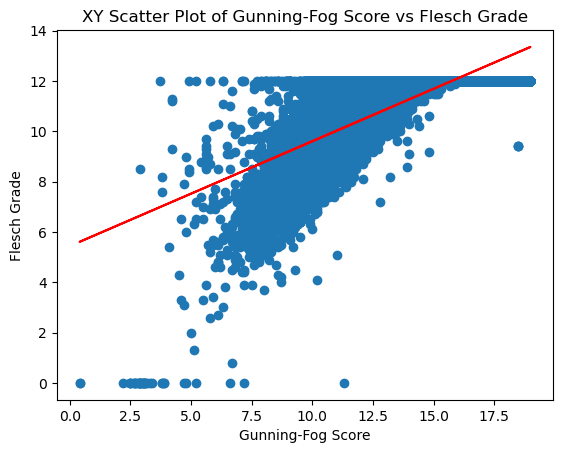

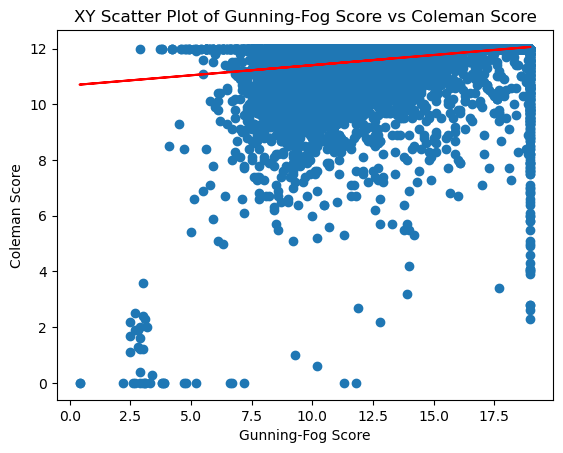

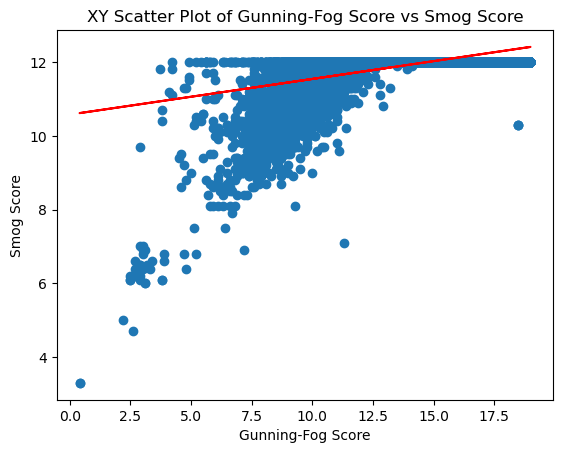

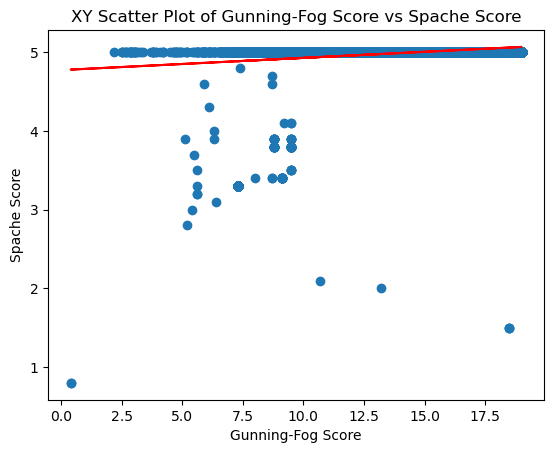

In [442]:
col_1 = 'Gunning-Fog Score'
for col_2 in df.columns:
    plot(df, col_1, col_2)